In [1]:
'''
Setting Wandb project credentials
'''
entity="cs21m007_cs21m013"
project="checking"

In [2]:
'''
Class: Layer
Definations: Initialize_params, activation_fn
'''

import numpy as np  # numpy for implementing array operations inside the functions.
class Layer:
    '''
    Method: __init__ constructor for base initializations
    Input: no of hidden units of the layer, activation for the layer
    Output: None
    '''
    def __init__(self, hidden_units: int, activation:str=None):
        self.hidden_units = hidden_units
        self.activation = activation
        self.W = None
        self.b = None
    '''
    Method: intialize_params for initializing the weights and biases of each layer
    Input: dimension of the input to the layer, no of hidden neurons in the layer, the initialization type(Random or Xavier)
    Output: None
    ''' 
    def initialize_params(self, n_in, hidden_units,init_type):
        np.random.seed(2)
        if init_type=="Random":
            self.W = 0.01*np.random.randn(n_in, hidden_units)
            self.b = 0.01*np.random.randn(1,hidden_units)

        elif init_type=="Xavier":
            self.W = np.random.randn(n_in, hidden_units) * np.sqrt(2/n_in) 
            self.b = np.zeros((1, hidden_units))

    '''
    Method: activation_fn for defining the activation functions and thier derivatives to be used by the layers
    Input: The computed pre activation of each layer
    Output: calculates the activation value for forward prop or the derivative of the activation for backward prop
    '''
    def activation_fn(self, z, derivative=False):
        '''
        Relu activation and its derivative
        '''
        if self.activation == 'relu':
            if derivative:
                return np.where(z<=0,0,1)
            return np.maximum(0, z)
        '''
        sigmoid activation and its derivative
        '''
        if self.activation == 'sigmoid':
            if derivative:
                return (1 / (1 + np.exp(-z))) * (1-(1 / (1 + np.exp(-z))))
            return (1 / (1 + np.exp(-z)))
        '''
        tanh activation and its derivative
        '''
        if self.activation == 'tanh':
            t=(np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
            if derivative:
                return (1-t**2)
            return t
        '''
        softmax function and its derivativ for the output layer with 10 neurons.
        '''
        if self.activation == 'softmax':
            if derivative: 
                exp = np.exp(z - np.max(z, axis=1, keepdims=True))
                return exp / np.sum(exp, axis=0) * (1 - exp / np.sum(exp, axis=0))
            exp = np.exp(z - np.max(z, axis=1, keepdims=True))
            return exp / np.sum(exp, axis=1, keepdims=True)

In [3]:
'''
Class: Helper
Definations: Accruacy function, compute_loss function, create batches function.
'''
import numpy as np  # numpy for performing array operations.
class Helper:
    '''
    Method: accuracy
    Input: the true labels and the predicted proababilities generated by the model.
    Output: Returns the accuracy of the model on the data.
    '''
    def accuracy(self,y,y_hat):
        c = np.argmax(y_hat, axis=1) == np.argmax(y, axis=1)
        acc = list(c).count(True) / len(c) * 100
        return acc

    '''
    Method: compute_loss
    Input: the true label, predicted probabilities, loss_type(SquarredError or CrossEntropy) and the regularization coefficient if any.
    Output: Returns the value of the loss (SE or CE) plus the regularization loss if any.
    '''
    def compute_loss(self,Y, Y_hat,layers,loss_type="CrossEntropy",reg=0):
        if loss_type=="CrossEntropy":
            m = Y.shape[0]
            L = -1./m * np.sum(Y * np.log(Y_hat+0.0000000001))
        elif loss_type=="SquaredError":
            L = np.mean((Y- Y_hat)**2)

        if reg!=0:
            reg_error = 0.0                                                                       
            for idx in layers.keys() :
              reg_error += (reg/2)*(np.sum(np.square(layers[idx].W))) 
            L = L + reg_error

        return L
    
    '''
    Method: create_batches depending on the batch size for training
    Input: the training data (X,y) and the batch size
    Ouput: Batches of data for training based on the batch size.
    '''
    def create_batches(self,x, y, batch_size):
        m = x.shape[0]
        num_batches = m / batch_size
        batches = []
        for i in range(int(num_batches+1)):
            batch_x = x[i*batch_size:(i+1)*batch_size]
            batch_y = y[i*batch_size:(i+1)*batch_size]
            batches.append((batch_x, batch_y))
        
        if m % batch_size == 0:
            batches.pop(-1)

        return batches
    

In [18]:
'''
Clss: Neural_Network
Definitions: Constructor __init__, add , forward, backward, GDoptimize, 
              SGDMoptimize, Nesterovoptimize, RMSpropoptimize, Adamoptimize, 
              Nadamoptimize, fit, predict
'''
import numpy as np  # numpy to tackle all array related operations
from sklearn.model_selection import train_test_split  # train test split for splitting the train data into further train and validation.
class Neural_Network:
    '''
    Method: __init__ constructor for base initialization of layers, cache and gradients for each layer.
    Input: None
    Output: None
    '''
    def __init__(self):
        self.layers = dict()
        self.cache = dict()
        self.grads = dict()

    '''
    Method: add, to add the layer objects to the model (object of neural network).
    Input: layer dictionary
    Output: None
    '''    
    def add(self, layer):
        self.layers[len(self.layers)+1] = layer

    '''
    Method: forward, for forward propagation of the model.
    Input: input data and the initilization type of the W,b's of the layer
    Output: Returns the predicted probability distribution after forward propagation
    '''
    def forward(self, x, init_type="Xavier"):
        for idx, layer in self.layers.items():

            layer.input = np.array(x, copy=True)
            if layer.W is None:
                layer.initialize_params(layer.input.shape[-1], layer.hidden_units,init_type)  # initilaize the weights and the biases.

            layer.Z = x @ layer.W + layer.b # linear pre activation
        
            if layer.activation is not None:
                layer.A = layer.activation_fn(layer.Z) #applying non-linear activation function
                x = layer.A
            else:
                x = layer.Z
            self.cache[f'W{idx}'] = layer.W # storing the weights of the layer
            self.cache[f'Z{idx}'] = layer.Z # storing the pre activation values of each layer
            self.cache[f'A{idx}'] = layer.A # storing the activation values of each layer.
        return x

    '''
    Method: backward, for backward propagation for generating the gradients for weight updation.
    Input: true labels, loss_type, regularization coefficient
    Output: None, but save the gradients in the grad dictionary of the model(Neural Network object)
    '''
    def backward(self, y, loss_type,reg=0):
        last_layer_idx = max(self.layers.keys())
        m = y.shape[0]
        for idx in reversed(range(1, last_layer_idx+1)):  # move from output to inputs
            if idx == last_layer_idx:
                if loss_type=="CrossEntropy":
                    self.grads[f'dZ{idx}'] = self.cache[f'A{idx}'] - y  # gradient wrt output layer for cross entropy loss
                elif loss_type=="SquaredError":
                    self.grads[f'dZ{idx}'] = (self.cache[f'A{idx}'] - y) * self.layers[idx].activation_fn(self.cache[f'Z{idx}'], derivative=True) # gradients wrt output layer for squared error loss
            else:
                self.grads[f'dZ{idx}'] = self.grads[f'dZ{idx+1}'] @ self.cache[f'W{idx+1}'].T *\
                                        self.layers[idx].activation_fn(self.cache[f'Z{idx}'], derivative=True) # gradients directly wrt to the pre-activation for each layer.


            self.grads[f'dW{idx}'] = 1 / m * self.layers[idx].input.T @ self.grads[f'dZ{idx}'] + reg*self.layers[idx].W # gradients wrt the weights of each layer
            self.grads[f'db{idx}'] = 1 / m * np.sum(self.grads[f'dZ{idx}'], axis=0, keepdims=True)  # gradients wrt the biases of each layer.
            
            assert self.grads[f'dW{idx}'].shape == self.cache[f'W{idx}'].shape

    '''
    Method: GDoptimize, basically the vanilla gradient descent
    Input: learning_rate, idx indicating the layer index
    Output: None, but performs the weight updations wrt the gradients.
    '''
    def GDoptimize(self, idx, learning_rate=1e-3):
        
        self.layers[idx].W -= learning_rate * self.grads[f'dW{idx}']  # W update
        self.layers[idx].b -= learning_rate * self.grads[f'db{idx}']  # b update

    '''
    Method: SGDMoptimize, basically the momemtum based gradient descent.
    Input: learning_rate, idx, mu - fixed momentum coefficient
    Output: None, but weights, biases are updated
    '''
    def SGDMoptimize(self, idx, learning_rate=1e-3, mu=0.99):
        m = dict()
        for i in self.layers.keys():
            m[f'W{i}'] = 0
            m[f'b{i}'] = 0

        m[f'W{idx}'] = m[f'W{idx}'] * mu - learning_rate * self.grads[f'dW{idx}'] # momentum wrt W
        m[f'b{idx}'] = m[f'b{idx}'] * mu - learning_rate * self.grads[f'db{idx}'] # momentum wrt b

        self.layers[idx].W += m[f'W{idx}']  # W update
        self.layers[idx].b += m[f'b{idx}']  # b update

    '''
    Method: Nesterovoptimize, nesterov accelerated gradien descent.
    Input: learning rate, mu - fixed momentum coefficient, idx of the layer
    Output: None, but updates the parameters(W,b)
    '''
    def Nesterovoptimize(self, idx, learning_rate=1e-3, mu=0.99):
        m = dict()
        for i in self.layers.keys():
            m[f'W{i}'] = 0
            m[f'b{i}'] = 0

        mW_prev =  np.array(m[f'W{idx}'], copy=True)
        mb_prev = np.array(m[f'b{idx}'], copy=True)

        m[f'W{idx}'] = m[f'W{idx}'] * mu - learning_rate * self.grads[f'dW{idx}'] # moemtum update wrt W
        m[f'b{idx}'] = m[f'b{idx}'] * mu - learning_rate * self.grads[f'db{idx}'] # momentum update wrt b
        # using the lookaheads
        w_update = -mu * mW_prev + (1 + mu) * m[f'W{idx}'] 
        b_update = -mu * mb_prev + (1 + mu) * m[f'b{idx}']

        self.layers[idx].W += w_update  # W update
        self.layers[idx].b += b_update  # b update

    '''
    Method: RMSpropoptimize, basicall RMSprop gradient descent.
    Input: idx of layer, learning rate, decay rate and epsilon
    Output: None, updates the parameters.
    '''
    def RMSpropoptimize(self, idx, learning_rate=1e-3,decay_rate=0.99, epsilon=1e-8):
        v = dict()
        for i in self.layers.keys():
            v[f'W{i}'] = 0
            v[f'b{i}'] = 0
        # using the learning rate decay
        v[f'W{idx}'] = decay_rate * v[f'W{idx}'] + (1 - decay_rate) * self.grads[f'dW{idx}'] **2 
        v[f'b{idx}'] = decay_rate * v[f'b{idx}'] + (1 - decay_rate) * self.grads[f'db{idx}'] **2
        # update values calculation    
        w_update = -learning_rate * self.grads[f'dW{idx}'] / (np.sqrt(v[f'W{idx}'] + epsilon))
        b_update = -learning_rate * self.grads[f'db{idx}'] / (np.sqrt(v[f'b{idx}']+ epsilon))

        self.layers[idx].W += w_update  # W update
        self.layers[idx].b += b_update  # b update

    '''
    Method: Adamoptimize, Adam optimizer
    Input: idx,steps,learing rate, beta1, beta2 and epsilon
    Ouput: None, but updates the parameters
    '''
    def Adamoptimize(self, idx, steps, learning_rate=1e-3, beta1=0.99, beta2=0.999, epsilon=1e-8): 
        m = dict()
        v = dict()

        for i in self.layers.keys():
            m[f'W{i}'] = 0
            m[f'b{i}'] = 0
            v[f'W{i}'] = 0
            v[f'b{i}'] = 0

        dW = self.grads[f'dW{idx}']
        db = self.grads[f'db{idx}']

        # weights
        m[f'W{idx}'] = beta1 * m[f'W{idx}'] + (1 - beta1) * dW
        v[f'W{idx}'] = beta2 * v[f'W{idx}'] + (1 - beta2) * dW ** 2 
        
        # biases
        m[f'b{idx}'] = beta1 * m[f'b{idx}'] + (1 - beta1) * db
        v[f'b{idx}'] = beta2 * v[f'b{idx}'] + (1 - beta2) * db ** 2 

        # take timestep into account for bias correction
        mt_w  = m[f'W{idx}'] / (1 - beta1 ** steps) #accumulated history
        vt_w = v[f'W{idx}'] / (1 - beta2 ** steps)

        mt_b  = m[f'b{idx}'] / (1 - beta1 ** steps) #accumulated history
        vt_b = v[f'b{idx}'] / (1 - beta2 ** steps)

        w_update = - learning_rate * mt_w / (np.sqrt(vt_w) + epsilon)
        b_update = - learning_rate * mt_b / (np.sqrt(vt_b) + epsilon)

        self.layers[idx].W += w_update  # W update
        self.layers[idx].b += b_update  # b update

    '''
    Method: Nadamoptimize, nesterov accelerated Adam
    Input: idx of layer, steps, learing rate, beat1, beta2, epsilon
    Output: None, but updates the parameters.
    '''
    def Nadamoptimize(self, idx, steps,learning_rate=1e-3, beta1=0.99, beta2=0.999, epsilon=1e-8): 
        m = dict()
        v = dict()

        for i in self.layers.keys():
            m[f'W{i}'] = 0
            m[f'b{i}'] = 0
            v[f'W{i}'] = 0
            v[f'b{i}'] = 0
        dW = self.grads[f'dW{idx}']
        db = self.grads[f'db{idx}']
        # weights
        m[f'W{idx}'] = beta1 * m[f'W{idx}'] + (1 - beta1) * dW
        v[f'W{idx}'] = beta2 * v[f'W{idx}'] + (1 - beta2) * dW ** 2 
            
        # biases
        m[f'b{idx}'] = beta1 * m[f'b{idx}'] + (1 - beta1) * db
        v[f'b{idx}'] = beta2 * v[f'b{idx}'] + (1 - beta2) * db ** 2 

        # take timestep into account for bias correction
        mt_w  = m[f'W{idx}'] / (1 - beta1 ** steps) #accumulated history
        vt_w = v[f'W{idx}'] / (1 - beta2 ** steps)

        mt_b  = m[f'b{idx}'] / (1 - beta1 ** steps) #accumulated history
        vt_b = v[f'b{idx}'] / (1 - beta2 ** steps)
        # accelerated momentum incorporation into adam
        w_update = - learning_rate / (np.sqrt(vt_w) + epsilon) * (beta1 * mt_w + (1 - beta1) *  dW / (1 - beta1 ** steps))
        b_update = - learning_rate / (np.sqrt(vt_b) + epsilon) * (beta1 * mt_b + (1 - beta1) *  db / (1 - beta1 ** steps))

        self.layers[idx].W += w_update  # W update
        self.layers[idx].b += b_update  #b update
            
    '''
    Method: fit, used to train the model by combining forward_prop, back_prop and gradient descent weight updation.
    Input: Training data, batch_size, epochs, learning rate, optimizer to use, val_split factor, initialization type of the weights and biases, loss type, and the regularization coefficient
    Output: None, but performs the training of the model 
    '''
    def fit(self, x_train, y_train,batch_size=32,epochs=500, learning_rate=1e-3, optimizer="GD",val_split=0.1,init_type="Xavier",loss_type="CrossEntropy",reg=0):
        train_accs = [] #stores the training accuracy for each epoch
        val_accs = [] #stores the validation accuracy after each epoch
        help=Helper() #creating a object of the Helper class for helper functions
        
        '''Initializations'''
        self.epochs = epochs
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.init_type=init_type
        self.reg=reg
        self.loss_type=loss_type

        '''Splitting the training data into train and val data based on the val_split value''' 
        x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=val_split,stratify=y_train,random_state=42)

        '''Training Cycle'''
        for i in range(1, self.epochs+1):
            print(f'Epoch {i}')
            batches = help.create_batches(x_train, y_train, batch_size) # create batches based on the batch size
            epoch_loss = []
            steps = 0 #count the steps in each epoch
            
            for x, y in batches:
                steps += 1
                '''Forward Propagation'''
                preds = self.forward(x,self.init_type)
   
                '''backward propagation'''
                self.backward(y,self.loss_type,self.reg)
                
                '''update weights and biases of each layer using the corresponding optimizer'''
                for idx in self.layers.keys():
                    if self.optimizer =="GD":
                        self.GDoptimize(idx, learning_rate=self.learning_rate)
                    elif self.optimizer=="SGDM":
                        self.SGDMoptimize(idx, learning_rate=self.learning_rate)
                    elif self.optimizer=="Nesterov":
                        self.Nesterovoptimize(idx, learning_rate=self.learning_rate)
                    elif self.optimizer=="RMSprop":
                        self.RMSpropoptimize(idx, learning_rate=self.learning_rate)
                    elif self.optimizer=="Adam":
                        self.Adamoptimize(idx, steps, learning_rate=self.learning_rate)
                    elif self.optimizer=="Nadam":
                        self.Nadamoptimize(idx, steps, learning_rate=self.learning_rate)
                
            '''Predict with network on x_train'''
            train_preds = self.forward(x_train)
            train_loss = help.compute_loss(y, preds,self.layers,self.loss_type,self.reg)
            train_acc=help.accuracy(train_preds,y_train)
            train_accs.append(train_acc)
            
            '''predcit with network on validation data'''
            val_preds = self.forward(x_val)
            val_acc=help.accuracy(val_preds,y_val)
            val_accs.append(val_acc)
            val_loss = help.compute_loss(y_val, val_preds,self.layers,self.loss_type,self.reg)

            print(f'Train Loss:{train_loss} Train Acc: {train_acc} Val Acc: {val_acc} Val Loss: {val_loss}')  # printing the losses and accuracy after each epoch  
            '''Wandb logging values of Train accuracy, Train loss, val accuracy and val loss'''
            '''wandb.log(
        {"Train/Loss": train_loss, "Train/Accuracy": train_acc, "Val/Accuracy": val_acc, "Val/Loss":val_loss,"Epoch":i})'''
                
          

    '''
    Method: Predict, model predictions on any data
    Input: Test data to predict on
    Output: predicted probabilities of the model on the test data.
    '''
    def predict(self,x):
        preds=self.forward(x)
        return preds

**Main**

In [19]:
'''Installing wandb and login'''
! pip install wandb
! wandb login

wandb: Currently logged in as: cs21m013 (use `wandb login --relogin` to force relogin)


In [20]:
'''
Essential Imports including the dataset library.
'''
from keras.datasets import fashion_mnist # dataset to work on.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb

In [21]:
'''Datset loading'''
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

**Data Preparation**

In [22]:
class_type = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 

In [23]:
'''
generating a class list to pass as alist in the confucion matrix.
'''
class_list=[]
for i in range(10):
    for j in range(len(y_train)):
        if y_train[j] == i :
            class_list.append(class_type[y_train[j]])
            break

In [24]:
'''
For plotting the images one for each class label
'''
images=[]
labels=[]
i=0
while(len(labels)<10):
  if y_train[i] not in labels:
    labels.append(y_train[i])
    images.append(x_train[i])
    
  i+=1

In [25]:
'''Date preprcessing'''
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print(x_train.shape, x_test.shape)
x_train = np.array(x_train/255., dtype=np.float32)
x_test = np.array(x_test/255., dtype=np.float32)

(60000, 784) (10000, 784)


In [26]:
'''Method to make labels into a onehot vector'''
def one_hot(Y):
    num_labels = len(set(Y))
    new_Y = []
    for label in Y:
        encoding = np.zeros(num_labels)
        encoding[label] = 1.
        new_Y.append(encoding)
    return np.array(new_Y)

In [27]:
'''Label conversion to onehot vectors'''
y_train = one_hot(y_train)
y_test = one_hot(y_test)
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

**Individual Checking for trying out the network implementation**


In [28]:
'''
Individual testing hyper parameters
'''
epochs = 5
lr = 1e-3
batch_size = 16
optimizer="Adam"
init_type="Xavier"
loss_type="CrossEntropy"
reg=0

In [29]:
'''
Building the model training
'''
model = Neural_Network()
model.add(Layer(64, activation='tanh'))
model.add(Layer(64, activation='tanh'))
model.add(Layer(64, activation='tanh'))
model.add(Layer(10, activation='softmax'))
print(model.layers)
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, learning_rate=lr, optimizer=optimizer,val_split=0.1,init_type=init_type,loss_type=loss_type,reg=reg)

{1: <__main__.Layer object at 0x7f167d3c5ed0>, 2: <__main__.Layer object at 0x7f167d3c5fd0>, 3: <__main__.Layer object at 0x7f167d3c5f50>, 4: <__main__.Layer object at 0x7f167d3c5f10>}
Epoch 1
Train Loss:0.5874531982283332 Train Acc: 82.22777777777777 Val Acc: 82.1 Val Loss: 0.5288431504912403
Epoch 2
Train Loss:0.5428387452517958 Train Acc: 83.82222222222222 Val Acc: 83.39999999999999 Val Loss: 0.49095292209134417
Epoch 3
Train Loss:0.3587349996224176 Train Acc: 84.58518518518518 Val Acc: 84.06666666666666 Val Loss: 0.48617068573084665
Epoch 4
Train Loss:0.40987328600002215 Train Acc: 84.93333333333334 Val Acc: 84.43333333333334 Val Loss: 0.47476441030939726
Epoch 5
Train Loss:0.33601677639838284 Train Acc: 84.79629629629629 Val Acc: 84.36666666666667 Val Loss: 0.47690453098733876


**Wandb Sweep for all hyper parameters**

In [ ]:
'''
Hyper paramter sets for tuning the model on different combinations of the hyper parameters.
Using the sweep functionality of Wandb 
'''
sweep_config = {
    'method': 'random', #bayes, random, grid methods can be used for tuning.
    'metric': {
      'name': 'Val/Accuracy', # goal is to maximize the validation accuracy.
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'no_hidden_layer':{
            'values': [3,4,5]  
        },
        'learning_rate': {
            'values': [1e-3,1e-4]
        },
        'opt': {
            'values': ['gd','sgdm','nesterov','rmsprop','adam','nadam']
        },
        'activation': {
            'values': ['relu', 'sigmoid','tanh']
        },
        'batch_size':{
            'values':[16,32,64]
        },
        'size_hidden':{
            'values':[32,64,128]
        },
        'reg':{
            'values': [0,0.0005,0.5]
        },
        'init_type':{
            'values': ['Xavier','Random']  
        }
    }
}

In [ ]:
'''
Project initialization in Wandb
'''
sweep_id = wandb.sweep(sweep_config, entity=entity, project=project)

Create sweep with ID: v47yr7c9
Sweep URL: https://wandb.ai/cs21m007_cs21m013/Assignment_1_random_randomSeed_SE/sweeps/v47yr7c9


In [ ]:
'''
Method: train for sweeping in wandb for hyper paramter tuning.
'''
def train():
    steps = 0
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 5,
        'no_hidden_layer':3,
        'learning_rate': 1e-3,
        'opt':'adam',
        'activation':'sigmoid',
        'batch_size':16,
        'size_hidden':32,
        'reg':0,
        'init_type':'Xavier'
    }

    # Initialize a new wandb run
    wandb.init(project=project, entity=entity,config=config_defaults)
    
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    lr = config.learning_rate
    epochs = config.epochs
    opt = config.opt
    acti=config.activation
    batch_size = config.batch_size
    hidden_size=config.size_hidden
    reg=config.reg
    init_type=config.init_type
    no_hidden_layer=config.no_hidden_layer
    if opt=="gd":
        opt="GD"
    elif opt=='adam':
      opt="Adam"
    elif opt=='rmsprop':
      opt="RMSprop"
    elif opt=='sgdm':
      opt='SGDM'
    elif opt=='nadam':
      opt="Nadam"
    elif opt=='nesterov':
      opt="Nesterov"
    # Model training and sweeping the value
    model = Neural_Network()
    for i in range(no_hidden_layer):
        model.add(Layer(hidden_size, activation=acti))

    model.add(Layer(10, activation='softmax'))
    print(model.layers)
    model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, learning_rate=lr, optimizer=opt,val_split=0.1,init_type=init_type,loss_type="SquaredError",reg=reg)

In [ ]:
wandb.agent(sweep_id, train,count=100)

wandb: Agent Starting Run: pe2w1cdo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: sgdm
wandb: 	reg: 0.5
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=tanh, 2: Hidden Units=32; Activation=tanh, 3: Hidden Units=32; Activation=tanh, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.7255815610629746 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.7255709561780603
Epoch 2
Train Loss:0.6741395389252024 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.6741290098415268
Epoch 3
Train Loss:0.6268611486038591 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.6268506911018684
Epoch 4
Train Loss:0.5834093925413802 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.583399002719291
Epoch 5
Train Loss:0.5434745492176954 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.5434642234590679


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▆▄▃▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▆▄▃▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.54347
Val/Accuracy,10.0
Val/Loss,0.54346


wandb: Agent Starting Run: zbv6euu1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 5
wandb: 	opt: nadam
wandb: 	reg: 0.5
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=relu, 2: Hidden Units=32; Activation=relu, 3: Hidden Units=32; Activation=relu, 4: Hidden Units=32; Activation=relu, 5: Hidden Units=32; Activation=relu, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09001526020046899 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000733419704361
Epoch 2
Train Loss:0.0900053529062804 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000723002878841
Epoch 3
Train Loss:0.08999547046565898 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0900071372207669
Epoch 4
Train Loss:0.08998564182379483 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000710810787714
Epoch 5
Train Loss:0.08997583787336763 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000710501913897


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▆▄▃▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▅▂▁▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.08998
Val/Accuracy,10.0
Val/Loss,0.09001


wandb: Agent Starting Run: pb61pv3q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 5
wandb: 	opt: nadam
wandb: 	reg: 0
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=tanh, 2: Hidden Units=64; Activation=tanh, 3: Hidden Units=64; Activation=tanh, 4: Hidden Units=64; Activation=tanh, 5: Hidden Units=64; Activation=tanh, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.025099510214620598 Train Acc: 79.95925925925927 Val Acc: 79.88333333333333 Val Loss: 0.029313638736368813
Epoch 2
Train Loss:0.021904429627830693 Train Acc: 82.55185185185185 Val Acc: 82.13333333333334 Val Loss: 0.0252441586667399
Epoch 3
Train Loss:0.021259047084383705 Train Acc: 83.89259259259259 Val Acc: 83.18333333333334 Val Loss: 0.023747102824203233
Epoch 4
Train Loss:0.021037565413815858 Train Acc: 84.5 Val Acc: 84.11666666666666 Val Loss: 0.02295475298718553
Epoch 5
Train Loss:0.02118301780894439 Train Acc: 84.99074074074075 Val Acc: 84.31666666666666 Val Loss: 0.02250081615426546
Epoch 6
Train Loss:0.020628944302309278 Train Acc: 85.31111111111112 Val Acc: 84.5 Val Loss: 0.02215503665082374
Epoch 7
Train Loss:0.019894212737420487 Trai

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▄▅▆▇▇▇███
Train/Loss,█▅▄▄▄▄▃▂▁▁
Val/Accuracy,▁▄▅▇▇▇████
Val/Loss,█▄▃▂▂▂▂▁▁▁
Epoch,10
Train/Accuracy,86.27222
Train/Loss,0.01783
Val/Accuracy,85.23333
Val/Loss,0.02125


wandb: Agent Starting Run: p9t9sm4l with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: sgdm
wandb: 	reg: 0
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=sigmoid, 2: Hidden Units=128; Activation=sigmoid, 3: Hidden Units=128; Activation=sigmoid, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.0899276959993934 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001802902064236
Epoch 2
Train Loss:0.08992834377138063 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001742604028601
Epoch 3
Train Loss:0.08992899630838427 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001684339363157
Epoch 4
Train Loss:0.08992965298536461 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0900162803858451
Epoch 5
Train Loss:0.08993031320740813 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001573634638518


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,▁▃▄▆█
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▆▄▃▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.08993
Val/Accuracy,10.0
Val/Loss,0.09002


wandb: Agent Starting Run: c2uc6ii1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 5
wandb: 	opt: adam
wandb: 	reg: 0
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=tanh, 2: Hidden Units=32; Activation=tanh, 3: Hidden Units=32; Activation=tanh, 4: Hidden Units=32; Activation=tanh, 5: Hidden Units=32; Activation=tanh, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.0419412323174644 Train Acc: 71.30740740740741 Val Acc: 70.76666666666667 Val Loss: 0.047510302088275454
Epoch 2
Train Loss:0.02706387725386473 Train Acc: 77.25925925925927 Val Acc: 76.6 Val Loss: 0.0366521526598041
Epoch 3
Train Loss:0.021300398119811763 Train Acc: 79.2462962962963 Val Acc: 78.91666666666667 Val Loss: 0.03189464044383058
Epoch 4
Train Loss:0.018237994080379995 Train Acc: 80.38518518518518 Val Acc: 79.98333333333333 Val Loss: 0.029497703051132976
Epoch 5
Train Loss:0.01633203038059588 Train Acc: 81.09814814814816 Val Acc: 80.73333333333333 Val Loss: 0.028065312581252645
Epoch 6
Train Loss:0.014924676699161938 Train Acc: 81.73703703703704 Val Acc: 81.16666666666667 Val Loss: 0.02709014105992604
Epoch 7
Train Loss:0.0139922118453

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▅▆▆▇▇▇███
Train/Loss,█▄▃▂▂▂▁▁▁▁
Val/Accuracy,▁▄▆▆▇▇▇███
Val/Loss,█▅▃▂▂▂▁▁▁▁
Epoch,10
Train/Accuracy,83.17407
Train/Loss,0.01269
Val/Accuracy,82.6
Val/Loss,0.02511


wandb: Agent Starting Run: 6pe7pp4b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 4
wandb: 	opt: nadam
wandb: 	reg: 0
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=tanh, 2: Hidden Units=32; Activation=tanh, 3: Hidden Units=32; Activation=tanh, 4: Hidden Units=32; Activation=tanh, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.028834495513460144 Train Acc: 82.64444444444445 Val Acc: 82.41666666666667 Val Loss: 0.02623252617180324
Epoch 2
Train Loss:0.026996359394726062 Train Acc: 83.08518518518518 Val Acc: 82.43333333333334 Val Loss: 0.02529888491132747
Epoch 3
Train Loss:0.02837440974237255 Train Acc: 83.01666666666667 Val Acc: 82.38333333333333 Val Loss: 0.025139790511938747
Epoch 4
Train Loss:0.026438263494518 Train Acc: 83.88888888888889 Val Acc: 83.55 Val Loss: 0.024275627771724668
Epoch 5
Train Loss:0.02742378444046335 Train Acc: 83.5 Val Acc: 83.21666666666667 Val Loss: 0.02500655124288737


Epoch,▁▃▅▆█
Train/Accuracy,▁▃▃█▆
Train/Loss,█▃▇▁▄
Val/Accuracy,▁▁▁█▆
Val/Loss,█▅▄▁▄
Epoch,5
Train/Accuracy,83.5
Train/Loss,0.02742
Val/Accuracy,83.21667
Val/Loss,0.02501


wandb: Agent Starting Run: u90qbxez with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: adam
wandb: 	reg: 0.5
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=tanh, 2: Hidden Units=32; Activation=tanh, 3: Hidden Units=32; Activation=tanh, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.1116525712778021 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.11164516320429667
Epoch 2
Train Loss:0.09011980860214662 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09011314506450376
Epoch 3
Train Loss:0.09000814392648644 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000248048689449
Epoch 4
Train Loss:0.09000689704275153 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000244033335525
Epoch 5
Train Loss:0.09000565421905608 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000240338505096
Epoch 6
Train Loss:0.09000441295576204 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000236814521981
Epoch 7
Train Loss:0.09000317497308288 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000233436942337
Epoch 8
Train Loss:0.09000193592404815 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000230335691249
Epoch 9
Train Loss:0.09000070044133406 Train Acc: 10.0 Va

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▁▁▁▁▁▁▁▁▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▁▁▁▁▁▁▁▁▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.09
Val/Accuracy,10.0
Val/Loss,0.09


wandb: Agent Starting Run: nn7tq2zw with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: sgdm
wandb: 	reg: 0
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=relu, 2: Hidden Units=64; Activation=relu, 3: Hidden Units=64; Activation=relu, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09098510482344706 Train Acc: 8.3 Val Acc: 7.916666666666666 Val Loss: 0.09135976604842652
Epoch 2
Train Loss:0.08997247652535056 Train Acc: 11.038888888888888 Val Acc: 10.633333333333333 Val Loss: 0.09023214776709723
Epoch 3
Train Loss:0.0892120014238215 Train Acc: 14.64074074074074 Val Acc: 14.249999999999998 Val Loss: 0.08941775258459196
Epoch 4
Train Loss:0.08862037791142782 Train Acc: 17.28148148148148 Val Acc: 17.166666666666668 Val Loss: 0.08877002126960912
Epoch 5
Train Loss:0.0881300901823118 Train Acc: 19.344444444444445 Val Acc: 19.083333333333332 Val Loss: 0.0882175588051579
Epoch 6
Train Loss:0.08774056861750101 Train Acc: 20.93148148148148 Val Acc: 20.716666666666665 Val Loss: 0.08770973961757314
Epoch 7
Train Loss:0.08740649218267299 Train Acc: 22.737037037037037 Val Acc: 22.516666666666666 Val Loss: 0

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▂▃▄▅▅▆▇▇█
Train/Loss,█▆▅▄▄▃▃▂▂▁
Val/Accuracy,▁▂▃▄▅▅▆▇▇█
Val/Loss,█▇▆▅▄▄▃▂▂▁
Epoch,10
Train/Accuracy,28.72222
Train/Loss,0.08641
Val/Accuracy,27.91667
Val/Loss,0.08566


wandb: Agent Starting Run: 70780ioy with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: sgdm
wandb: 	reg: 0
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=relu, 2: Hidden Units=64; Activation=relu, 3: Hidden Units=64; Activation=relu, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09098510482344706 Train Acc: 8.3 Val Acc: 7.916666666666666 Val Loss: 0.09135976604842652
Epoch 2
Train Loss:0.08997247652535056 Train Acc: 11.038888888888888 Val Acc: 10.633333333333333 Val Loss: 0.09023214776709723
Epoch 3
Train Loss:0.0892120014238215 Train Acc: 14.64074074074074 Val Acc: 14.249999999999998 Val Loss: 0.08941775258459196
Epoch 4
Train Loss:0.08862037791142782 Train Acc: 17.28148148148148 Val Acc: 17.166666666666668 Val Loss: 0.08877002126960912
Epoch 5
Train Loss:0.0881300901823118 Train Acc: 19.344444444444445 Val Acc: 19.083333333333332 Val Loss: 0.0882175588051579


Epoch,▁▃▅▆█
Train/Accuracy,▁▃▅▇█
Train/Loss,█▆▄▂▁
Val/Accuracy,▁▃▅▇█
Val/Loss,█▅▄▂▁
Epoch,5
Train/Accuracy,19.34444
Train/Loss,0.08813
Val/Accuracy,19.08333
Val/Loss,0.08822


wandb: Agent Starting Run: d44x1ojr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 5
wandb: 	opt: adam
wandb: 	reg: 0
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=relu, 2: Hidden Units=128; Activation=relu, 3: Hidden Units=128; Activation=relu, 4: Hidden Units=128; Activation=relu, 5: Hidden Units=128; Activation=relu, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.08998225327628569 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000100183587992
Epoch 2
Train Loss:0.08998033638870459 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000092780440672
Epoch 3
Train Loss:0.08997844120116362 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000083474605262
Epoch 4
Train Loss:0.08997640845548098 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000049310165686
Epoch 5
Train Loss:0.08979828811788705 Train Acc: 19.520370370370372 Val Acc: 19.53333333333333 Val Loss: 0.08981793585763825


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁█
Train/Loss,████▁
Val/Accuracy,▁▁▁▁█
Val/Loss,████▁
Epoch,5
Train/Accuracy,19.52037
Train/Loss,0.0898
Val/Accuracy,19.53333
Val/Loss,0.08982


wandb: Agent Starting Run: vhcmtuod with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: nesterov
wandb: 	reg: 0.0005
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=sigmoid, 2: Hidden Units=32; Activation=sigmoid, 3: Hidden Units=32; Activation=sigmoid, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09056083869710896 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09070519917732608
Epoch 2
Train Loss:0.09056444530450172 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09070375484857614
Epoch 3
Train Loss:0.09056794349930611 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09070237699131962
Epoch 4
Train Loss:0.09057133489366809 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09070106115693988
Epoch 5
Train Loss:0.0905746211850594 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0906998031953586
Epoch 6
Train Loss:0.09057780414414691 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0906985992349312
Epoch 7
Train Loss:0.09058088560368577 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09069744566371861
Epoch 8
Train Loss:0.09058386744835938 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09069633911203688
Epoch 9
Train Loss:0.09058675160549383 Train Acc: 

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,▁▂▃▄▄▅▆▇▇█
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▇▆▅▅▄▃▂▂▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.09059
Val/Accuracy,10.0
Val/Loss,0.09069


wandb: Agent Starting Run: 1z78y682 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 4
wandb: 	opt: nesterov
wandb: 	reg: 0.5
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=relu, 2: Hidden Units=32; Activation=relu, 3: Hidden Units=32; Activation=relu, 4: Hidden Units=32; Activation=relu, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.1738802608835912 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.1738785615402303
Epoch 2
Train Loss:0.09010294236609381 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09010124531355387
Epoch 3
Train Loss:0.09000179562396815 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.090000123497622
Epoch 4
Train Loss:0.09000164850892704 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000000134748738
Epoch 5
Train Loss:0.0900016242395695 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000000111721837


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▁▁▁▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▁▁▁▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.09
Val/Accuracy,10.0
Val/Loss,0.09


wandb: Agent Starting Run: 334kph1j with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: gd
wandb: 	reg: 0
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=sigmoid, 2: Hidden Units=128; Activation=sigmoid, 3: Hidden Units=128; Activation=sigmoid, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.0928337828473307 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0931340412937426
Epoch 2
Train Loss:0.09279852013149699 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09309598925833663
Epoch 3
Train Loss:0.09276374965591498 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09305850509595695
Epoch 4
Train Loss:0.09272946262230614 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09302157815571938
Epoch 5
Train Loss:0.09269565043440219 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09298519803523754


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▆▄▃▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▆▄▃▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.0927
Val/Accuracy,10.0
Val/Loss,0.09299


wandb: Agent Starting Run: s7xlnq51 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 3
wandb: 	opt: rmsprop
wandb: 	reg: 0.5
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=tanh, 2: Hidden Units=32; Activation=tanh, 3: Hidden Units=32; Activation=tanh, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.23420826908099296 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.2341520533837551
Epoch 2
Train Loss:0.23420738265050156 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.23415190606555708
Epoch 3
Train Loss:0.23420651527393865 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.23415175816873135
Epoch 4
Train Loss:0.2342056592839073 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.23415161039148555
Epoch 5
Train Loss:0.23420481454736336 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.23415146278678892
Epoch 6
Train Loss:0.23420398101785703 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.23415131539850287
Epoch 7
Train Loss:0.23420315859601154 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.23415116827333582
Epoch 8
Train Loss:0.2342023471915079 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.23415102145197897
Epoch 9
Train Loss:0.23420154667049148 Train Acc: 10.0 Val 

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▇▆▆▅▄▃▂▂▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▇▆▆▅▄▃▃▂▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.2342
Val/Accuracy,10.0
Val/Loss,0.23415


wandb: Agent Starting Run: iwxo6t6d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 5
wandb: 	opt: adam
wandb: 	reg: 0.0005
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=sigmoid, 2: Hidden Units=64; Activation=sigmoid, 3: Hidden Units=64; Activation=sigmoid, 4: Hidden Units=64; Activation=sigmoid, 5: Hidden Units=64; Activation=sigmoid, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09053260304635447 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09051720719203704
Epoch 2
Train Loss:0.09167949314409984 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09168868409242906
Epoch 3
Train Loss:0.0928898773411258 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09294901265048418
Epoch 4
Train Loss:0.09381944063673484 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09382139172106464
Epoch 5
Train Loss:0.09421555341797921 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0942207547922631
Epoch 6
Train Loss:0.09436196028139042 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09436343596730336
Epoch 7
Train Loss:0.09435584325128979 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09439193754371764
Epoch 8
Train Loss:0.09431915096689221 Train Acc: 10.0 Val Acc: 10.0

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,▁▃▅▇██████
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,▁▃▅▇██████
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.09418
Val/Accuracy,10.0
Val/Loss,0.09421


wandb: Agent Starting Run: ppqjxun3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 5
wandb: 	opt: rmsprop
wandb: 	reg: 0.5
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=sigmoid, 2: Hidden Units=64; Activation=sigmoid, 3: Hidden Units=64; Activation=sigmoid, 4: Hidden Units=64; Activation=sigmoid, 5: Hidden Units=64; Activation=sigmoid, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09009686699221446 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09018320426546907
Epoch 2
Train Loss:0.09010260304958595 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09018332621512967
Epoch 3
Train Loss:0.09010345994627078 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09018333542863964
Epoch 4
Train Loss:0.09010358849230946 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09018332089421803
Epoch 5
Train Loss:0.09010360919552465 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09018330257009721


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,▁▇███
Val/Accuracy,▁▁▁▁▁
Val/Loss,▁██▇▆
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.0901
Val/Accuracy,10.0
Val/Loss,0.09018


wandb: Agent Starting Run: c6176qga with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: rmsprop
wandb: 	reg: 0.0005
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=sigmoid, 2: Hidden Units=32; Activation=sigmoid, 3: Hidden Units=32; Activation=sigmoid, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.11339755051079037 Train Acc: 10.27037037037037 Val Acc: 10.25 Val Loss: 0.1133767648962169
Epoch 2
Train Loss:0.10030792140282808 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.10025588258820958
Epoch 3
Train Loss:0.09455535402929248 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0944911409783459
Epoch 4
Train Loss:0.09203373135626668 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09196542417541186
Epoch 5
Train Loss:0.09093230826369587 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09086282428006388
Epoch 6
Train Loss:0.09045215927599763 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09038251058368524
Epoch 7
Train Loss:0.09024289215993112 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09017342045264372
Epoch 8
Train Loss:0.09015156162996131 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09008237622976777
Epoch 9
Train Loss:0.09011156715653

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,█▁▁▁▁▁▁▁▁▁
Train/Loss,█▄▂▂▁▁▁▁▁▁
Val/Accuracy,█▁▁▁▁▁▁▁▁▁
Val/Loss,█▄▂▂▁▁▁▁▁▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.09009
Val/Accuracy,10.0
Val/Loss,0.09003


wandb: Agent Starting Run: kuf05r85 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 5
wandb: 	opt: nesterov
wandb: 	reg: 0
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=sigmoid, 2: Hidden Units=128; Activation=sigmoid, 3: Hidden Units=128; Activation=sigmoid, 4: Hidden Units=128; Activation=sigmoid, 5: Hidden Units=128; Activation=sigmoid, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.08992334552258639 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09016549511855285
Epoch 2
Train Loss:0.08997257074460038 Train Acc: 10.016666666666667 Val Acc: 10.0 Val Loss: 0.09001960030527231
Epoch 3
Train Loss:0.09001826756494656 Train Acc: 8.088888888888889 Val Acc: 8.166666666666666 Val Loss: 0.09000948457378784
Epoch 4
Train Loss:0.09003144077978671 Train Acc: 10.268518518518519 Val Acc: 10.316666666666666 Val Loss: 0.09000843983546719
Epoch 5
Train Loss:0.09003438904997378 Train Acc: 10.848148148148148 Val Acc: 10.85 Val Loss: 0.09000791127379178
Epoch 6
Train Loss:0.09003479119289033 Train Acc: 11.033333333333333 Val Acc: 11.016666666666666 Val Loss: 0.090007408685895
Epoch 7
Train Loss:0.0900345161135713 Train Acc: 11

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▅▅▁▆▇▇▇███
Train/Loss,▁▄▇███████
Val/Accuracy,▅▅▁▆▇▇▇███
Val/Loss,█▂▁▁▁▁▁▁▁▁
Epoch,10
Train/Accuracy,11.38333
Train/Loss,0.09003
Val/Accuracy,11.45
Val/Loss,0.09001


wandb: Agent Starting Run: agoohu22 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 5
wandb: 	opt: sgdm
wandb: 	reg: 0.0005
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=tanh, 2: Hidden Units=128; Activation=tanh, 3: Hidden Units=128; Activation=tanh, 4: Hidden Units=128; Activation=tanh, 5: Hidden Units=128; Activation=tanh, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.42385902977097656 Train Acc: 4.770370370370371 Val Acc: 4.35 Val Loss: 0.4248203689127818
Epoch 2
Train Loss:0.42292897637309795 Train Acc: 6.303703703703703 Val Acc: 5.966666666666667 Val Loss: 0.4239660349334132
Epoch 3
Train Loss:0.4220340115400099 Train Acc: 7.864814814814815 Val Acc: 7.916666666666666 Val Loss: 0.4231343859860856
Epoch 4
Train Loss:0.42118761842179353 Train Acc: 9.598148148148148 Val Acc: 9.766666666666666 Val Loss: 0.4223368187135698
Epoch 5
Train Loss:0.4203996460850536 Train Acc: 11.196296296296296 Val Acc: 11.4 Val Loss: 0.421581916097968
Epoch 6
Train Loss:0.41967564606673646 Train Acc: 12.590740740740742 Val Acc: 12.583333333333332 Val Loss: 0.4208746894781405
Epoch 7
Train Loss:0.41901658847892287 Train Acc: 1

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▂▃▄▅▆▇▇██
Train/Loss,█▇▆▅▄▃▃▂▂▁
Val/Accuracy,▁▂▃▄▅▆▇▇██
Val/Loss,█▇▆▅▄▄▃▂▂▁
Epoch,10
Train/Accuracy,16.23889
Train/Loss,0.41739
Val/Accuracy,16.11667
Val/Loss,0.4185


wandb: Agent Starting Run: vfta25jo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 4
wandb: 	opt: gd
wandb: 	reg: 0.5
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=tanh, 2: Hidden Units=128; Activation=tanh, 3: Hidden Units=128; Activation=tanh, 4: Hidden Units=128; Activation=tanh, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.21941349272849636 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.2194411730525863
Epoch 2
Train Loss:0.09439982582792251 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09442637521349947
Epoch 3
Train Loss:0.09012626839374795 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09015218225353118
Epoch 4
Train Loss:0.08998063718046302 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000601858312247
Epoch 5
Train Loss:0.08997611386389957 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000098992674145


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▁▁▁▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▁▁▁▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.08998
Val/Accuracy,10.0
Val/Loss,0.09


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9ti3r05x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: nesterov
wandb: 	reg: 0
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=tanh, 2: Hidden Units=128; Activation=tanh, 3: Hidden Units=128; Activation=tanh, 4: Hidden Units=128; Activation=tanh, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.0914656556232816 Train Acc: 7.064814814814816 Val Acc: 6.783333333333333 Val Loss: 0.09337628135026182
Epoch 2
Train Loss:0.08885735989572788 Train Acc: 9.246296296296297 Val Acc: 8.783333333333333 Val Loss: 0.09094367723888332
Epoch 3
Train Loss:0.08630466357359125 Train Acc: 13.3 Val Acc: 12.35 Val Loss: 0.08857757814552536
Epoch 4
Train Loss:0.08366510251505273 Train Acc: 19.833333333333332 Val Acc: 19.45 Val Loss: 0.08611532274170071
Epoch 5
Train Loss:0.08085248391051514 Train Acc: 28.61851851851852 Val Acc: 28.849999999999998 Val Loss: 0.08347824745336445
Epoch 6
Train Loss:0.0779567048582229 Train Acc: 37.4 Val Acc: 37.81666666666666 Val Loss: 0.08074950503524043
Epoch 7
Train Loss:0.07516588168556748 Train Acc: 43.861111111111114 Val Acc: 44.016666666666666 Val Loss: 

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▂▃▄▆▇▇██
Train/Loss,█▇▆▆▅▄▃▂▂▁
Val/Accuracy,▁▁▂▃▄▆▇▇██
Val/Loss,█▇▆▆▅▄▃▂▂▁
Epoch,10
Train/Accuracy,52.33333
Train/Loss,0.06794
Val/Accuracy,51.73333
Val/Loss,0.0712


wandb: Agent Starting Run: slgkk0er with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: sgdm
wandb: 	reg: 0.5
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=tanh, 2: Hidden Units=32; Activation=tanh, 3: Hidden Units=32; Activation=tanh, 4: Hidden Units=32; Activation=tanh, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.6957644362083252 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.6957472192870133
Epoch 2
Train Loss:0.6016765280967313 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.6016593390863444
Epoch 3
Train Loss:0.5222028930653678 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.5221857289393977
Epoch 4
Train Loss:0.4550735580624074 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.45505641644700423
Epoch 5
Train Loss:0.3983711353556704 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.3983540143639425
Epoch 6
Train Loss:0.35047605693336886 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.35045895504763713
Epoch 7
Train Loss:0.31002031541982705 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.31000323140679586
Epoch 8
Train Loss:0.2758483902228439 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.2758313230715539
Epoch 9
Train Loss:0.246984242

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▇▅▄▄▃▂▂▁▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▇▅▄▄▃▂▂▁▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.2226
Val/Accuracy,10.0
Val/Loss,0.22259


wandb: Agent Starting Run: myofceyh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 5
wandb: 	opt: gd
wandb: 	reg: 0.0005
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=tanh, 2: Hidden Units=128; Activation=tanh, 3: Hidden Units=128; Activation=tanh, 4: Hidden Units=128; Activation=tanh, 5: Hidden Units=128; Activation=tanh, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09417583071819056 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09419562339632308
Epoch 2
Train Loss:0.09417231265811003 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09419208171238914
Epoch 3
Train Loss:0.09416879755939815 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09418854302197256
Epoch 4
Train Loss:0.09416528541955768 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09418500732253257
Epoch 5
Train Loss:0.0941617762360935 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09418147461153069


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▆▄▃▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▆▄▃▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.09416
Val/Accuracy,10.0
Val/Loss,0.09418


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 02opma4y with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 4
wandb: 	opt: sgdm
wandb: 	reg: 0
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=relu, 2: Hidden Units=64; Activation=relu, 3: Hidden Units=64; Activation=relu, 4: Hidden Units=64; Activation=relu, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.08534872098653748 Train Acc: 21.438888888888886 Val Acc: 21.616666666666667 Val Loss: 0.08630038127135937
Epoch 2
Train Loss:0.07615959795123492 Train Acc: 46.16851851851852 Val Acc: 47.349999999999994 Val Loss: 0.07863639000818332
Epoch 3
Train Loss:0.05841128259118629 Train Acc: 59.77777777777777 Val Acc: 59.36666666666667 Val Loss: 0.06325638072013859
Epoch 4
Train Loss:0.03984260309156282 Train Acc: 65.98333333333333 Val Acc: 65.60000000000001 Val Loss: 0.049533359768903024
Epoch 5
Train Loss:0.03840975262822236 Train Acc: 65.1537037037037 Val Acc: 64.68333333333334 Val Loss: 0.04779129866140217


Epoch,▁▃▅▆█
Train/Accuracy,▁▅▇██
Train/Loss,█▇▄▁▁
Val/Accuracy,▁▅▇██
Val/Loss,█▇▄▁▁
Epoch,5
Train/Accuracy,65.1537
Train/Loss,0.03841
Val/Accuracy,64.68333
Val/Loss,0.04779


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vx88qyyn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: nadam
wandb: 	reg: 0.0005
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=tanh, 2: Hidden Units=128; Activation=tanh, 3: Hidden Units=128; Activation=tanh, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.07069680407647953 Train Acc: 46.03148148148148 Val Acc: 45.266666666666666 Val Loss: 0.07425612403848961
Epoch 2
Train Loss:0.06310840981298105 Train Acc: 57.364814814814814 Val Acc: 57.116666666666674 Val Loss: 0.06535043746588773
Epoch 3
Train Loss:0.05816885877359468 Train Acc: 61.41111111111112 Val Acc: 61.31666666666666 Val Loss: 0.06121353336328229
Epoch 4
Train Loss:0.048324487913058406 Train Acc: 72.61111111111111 Val Acc: 72.16666666666667 Val Loss: 0.05535455697596567
Epoch 5
Train Loss:0.042334033390241374 Train Acc: 74.72962962962964 Val Acc: 74.05000000000001 Val Loss: 0.05340789628002724
Epoch 6
Train Loss:0.04548855605398028 Train Acc: 75.73518518518519 Val Acc: 75.06666666666668 Val Loss: 0.05271750894405847
Epoch 7
Train Loss:0.046818325308544274 Train Acc: 75.93333333333334 Val Acc: 75.633333333

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▄▄▇▇█████
Train/Loss,█▆▅▂▁▂▂▂▂▂
Val/Accuracy,▁▄▅▇▇█████
Val/Loss,█▅▄▂▁▁▁▁▁▁
Epoch,10
Train/Accuracy,77.20926
Train/Loss,0.04508
Val/Accuracy,76.9
Val/Loss,0.05261


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hkpa8ska with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 5
wandb: 	opt: gd
wandb: 	reg: 0.5
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=tanh, 2: Hidden Units=128; Activation=tanh, 3: Hidden Units=128; Activation=tanh, 4: Hidden Units=128; Activation=tanh, 5: Hidden Units=128; Activation=tanh, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.23350198770897374 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.23352966805415018
Epoch 2
Train Loss:0.09488150086038374 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0949080502768018
Epoch 3
Train Loss:0.09014273646569966 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09016865035779764
Epoch 4
Train Loss:0.08998120017616014 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000658161089171
Epoch 5
Train Loss:0.08997613307770211 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000100917206058


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▁▁▁▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▁▁▁▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.08998
Val/Accuracy,10.0
Val/Loss,0.09


wandb: Agent Starting Run: 9t59g9n0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 3
wandb: 	opt: rmsprop
wandb: 	reg: 0
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=tanh, 2: Hidden Units=64; Activation=tanh, 3: Hidden Units=64; Activation=tanh, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.02223408530123642 Train Acc: 79.7388888888889 Val Acc: 78.9 Val Loss: 0.029312962137515174
Epoch 2
Train Loss:0.0205773520419207 Train Acc: 83.87962962962962 Val Acc: 83.01666666666667 Val Loss: 0.024131872180686402
Epoch 3
Train Loss:0.019332118071454664 Train Acc: 84.66111111111111 Val Acc: 83.55 Val Loss: 0.02359281190037633
Epoch 4
Train Loss:0.02502793460569232 Train Acc: 80.95185185185186 Val Acc: 80.31666666666666 Val Loss: 0.02791149649795301
Epoch 5
Train Loss:0.019206138731736926 Train Acc: 84.17222222222223 Val Acc: 83.78333333333333 Val Loss: 0.022838539918413146


Epoch,▁▃▅▆█
Train/Accuracy,▁▇█▃▇
Train/Loss,▅▃▁█▁
Val/Accuracy,▁▇█▃█
Val/Loss,█▂▂▆▁
Epoch,5
Train/Accuracy,84.17222
Train/Loss,0.01921
Val/Accuracy,83.78333
Val/Loss,0.02284


wandb: Agent Starting Run: nwfrlpg0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: gd
wandb: 	reg: 0.5
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=sigmoid, 2: Hidden Units=32; Activation=sigmoid, 3: Hidden Units=32; Activation=sigmoid, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.674001802867476 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.674137474782638
Epoch 2
Train Loss:0.5832808844577889 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.5834037494293757
Epoch 3
Train Loss:0.5066525658898351 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.5067636905705825
Epoch 4
Train Loss:0.4419277641472715 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.44202812785010764
Epoch 5
Train Loss:0.3872574334769228 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.38734793509729704
Epoch 6
Train Loss:0.3410797467707846 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.3411612111978059
Epoch 7
Train Loss:0.30207548131985995 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.3021486653677161
Epoch 8
Train Loss:0.26913033455071544 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.2691959324410189
Epoch 9
Train Loss:0.2413030933064343 Train Acc: 10.0 Val Acc

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▇▅▄▄▃▂▂▁▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▇▅▄▄▃▂▂▁▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.2178
Val/Accuracy,10.0
Val/Loss,0.21785


wandb: Agent Starting Run: mp6ga7fk with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 4
wandb: 	opt: adam
wandb: 	reg: 0.0005
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=tanh, 2: Hidden Units=64; Activation=tanh, 3: Hidden Units=64; Activation=tanh, 4: Hidden Units=64; Activation=tanh, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.08994616336753179 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0900115964306646
Epoch 2
Train Loss:0.08995624482495213 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0900368942739675
Epoch 3
Train Loss:0.08999374261238513 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09007546354355095
Epoch 4
Train Loss:0.09002965816852936 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.090112698636873
Epoch 5
Train Loss:0.09007596688128659 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0901567290082135
Epoch 6
Train Loss:0.0901149351318199 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09019557547624242
Epoch 7
Train Loss:0.09015174012041711 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09023253332148747
Epoch 8
Train Loss:0.09019137302146688 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0902708303356624
Epoch 9
Train Loss:0.09023

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,▁▁▂▃▄▅▅▆▇█
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,▁▂▂▃▄▅▆▆▇█
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.09027
Val/Accuracy,10.0
Val/Loss,0.09035


wandb: Agent Starting Run: neot5ws0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: gd
wandb: 	reg: 0.0005
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=tanh, 2: Hidden Units=128; Activation=tanh, 3: Hidden Units=128; Activation=tanh, 4: Hidden Units=128; Activation=tanh, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.35507352607690235 Train Acc: 6.472222222222222 Val Acc: 5.949999999999999 Val Loss: 0.3569169812810708
Epoch 2
Train Loss:0.3536365637489391 Train Acc: 7.072222222222223 Val Acc: 6.783333333333333 Val Loss: 0.35555382697932725
Epoch 3
Train Loss:0.35226321272477223 Train Acc: 7.9 Val Acc: 7.5166666666666675 Val Loss: 0.35426527841595973
Epoch 4
Train Loss:0.35092568129659546 Train Acc: 9.268518518518519 Val Acc: 8.833333333333334 Val Loss: 0.35301952508172474
Epoch 5
Train Loss:0.3496023454594036 Train Acc: 11.079629629629629 Val Acc: 10.283333333333333 Val Loss: 0.35179026257351664
Epoch 6
Train Loss:0.3482747109597672 Train Acc: 13.398148148148149 Val Acc: 12.45 Val Loss: 0.35055548744389675
Epoch 7
Train Loss:0.34692559254808575 Train Acc: 16.39814814814815 Val Acc: 15.633

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▂▂▃▄▅▇█
Train/Loss,█▇▆▆▅▄▃▃▂▁
Val/Accuracy,▁▁▁▂▂▃▄▅▆█
Val/Loss,█▇▆▆▅▄▃▃▂▁
Epoch,10
Train/Accuracy,28.82963
Train/Loss,0.34264
Val/Accuracy,29.03333
Val/Loss,0.34527


wandb: Agent Starting Run: 76c5glxp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: nadam
wandb: 	reg: 0
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=sigmoid, 2: Hidden Units=32; Activation=sigmoid, 3: Hidden Units=32; Activation=sigmoid, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.0897641845802017 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001356085812857
Epoch 2
Train Loss:0.08966821320230234 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001997964907062
Epoch 3
Train Loss:0.08964758985291513 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09002100902858627
Epoch 4
Train Loss:0.08962747796225164 Train Acc: 12.627777777777776 Val Acc: 12.833333333333332 Val Loss: 0.08999604464516348
Epoch 5
Train Loss:0.08944781095570165 Train Acc: 9.61111111111111 Val Acc: 9.933333333333334 Val Loss: 0.08987342452901831


Epoch,▁▃▅▆█
Train/Accuracy,▂▂▂█▁
Train/Loss,█▆▅▅▁
Val/Accuracy,▁▁▁█▁
Val/Loss,███▇▁
Epoch,5
Train/Accuracy,9.61111
Train/Loss,0.08945
Val/Accuracy,9.93333
Val/Loss,0.08987


wandb: Agent Starting Run: 2gypyvqu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 5
wandb: 	opt: nadam
wandb: 	reg: 0.0005
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=sigmoid, 2: Hidden Units=32; Activation=sigmoid, 3: Hidden Units=32; Activation=sigmoid, 4: Hidden Units=32; Activation=sigmoid, 5: Hidden Units=32; Activation=sigmoid, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09537921614972082 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.095596773018463
Epoch 2
Train Loss:0.09501535309776651 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09538284469315039
Epoch 3
Train Loss:0.09531667816908213 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09582649209301985
Epoch 4
Train Loss:0.09592245055744573 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09658289340076245
Epoch 5
Train Loss:0.0967684005707372 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09763118490249709


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,▂▁▂▅█
Val/Accuracy,▁▁▁▁▁
Val/Loss,▂▁▂▅█
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.09677
Val/Accuracy,10.0
Val/Loss,0.09763


wandb: Agent Starting Run: zx7yyiht with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 5
wandb: 	opt: nadam
wandb: 	reg: 0.5
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=sigmoid, 2: Hidden Units=32; Activation=sigmoid, 3: Hidden Units=32; Activation=sigmoid, 4: Hidden Units=32; Activation=sigmoid, 5: Hidden Units=32; Activation=sigmoid, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09044368302033999 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09043167592354924
Epoch 2
Train Loss:0.09041148499619826 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09041485259349798
Epoch 3
Train Loss:0.09038049795059117 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.090414369175659
Epoch 4
Train Loss:0.09036348779930727 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09041484752350328
Epoch 5
Train Loss:0.09033906975157782 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09041716406740807


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▆▄▃▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▁▁▁▂
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.09034
Val/Accuracy,10.0
Val/Loss,0.09042


wandb: Agent Starting Run: pl7pbqk4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: nadam
wandb: 	reg: 0
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=sigmoid, 2: Hidden Units=64; Activation=sigmoid, 3: Hidden Units=64; Activation=sigmoid, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.08560177619170513 Train Acc: 47.364814814814814 Val Acc: 47.21666666666667 Val Loss: 0.08580028185326026
Epoch 2
Train Loss:0.0795193549146902 Train Acc: 52.861111111111114 Val Acc: 52.2 Val Loss: 0.0798328066344832
Epoch 3
Train Loss:0.07308948625028458 Train Acc: 57.272222222222226 Val Acc: 56.45 Val Loss: 0.07345644170098978
Epoch 4
Train Loss:0.0671036696804719 Train Acc: 60.27037037037037 Val Acc: 59.13333333333334 Val Loss: 0.06790305049172389
Epoch 5
Train Loss:0.06168593704670856 Train Acc: 61.91481481481481 Val Acc: 60.88333333333333 Val Loss: 0.06332596989160495


Epoch,▁▃▅▆█
Train/Accuracy,▁▄▆▇█
Train/Loss,█▆▄▃▁
Val/Accuracy,▁▄▆▇█
Val/Loss,█▆▄▂▁
Epoch,5
Train/Accuracy,61.91481
Train/Loss,0.06169
Val/Accuracy,60.88333
Val/Loss,0.06333


wandb: Agent Starting Run: 4pkol4o7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 5
wandb: 	opt: sgdm
wandb: 	reg: 0
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=sigmoid, 2: Hidden Units=32; Activation=sigmoid, 3: Hidden Units=32; Activation=sigmoid, 4: Hidden Units=32; Activation=sigmoid, 5: Hidden Units=32; Activation=sigmoid, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09187493640371654 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09488916460858006
Epoch 2
Train Loss:0.09174590782811737 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09465492014634908
Epoch 3
Train Loss:0.09162733336345139 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0944368914160446
Epoch 4
Train Loss:0.0915181186174224 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09423359063518807
Epoch 5
Train Loss:0.09141730487248256 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09404369676276178


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▆▄▃▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▆▄▃▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.09142
Val/Accuracy,10.0
Val/Loss,0.09404


wandb: Agent Starting Run: x65fcv50 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: sgdm
wandb: 	reg: 0
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=relu, 2: Hidden Units=128; Activation=relu, 3: Hidden Units=128; Activation=relu, 4: Hidden Units=128; Activation=relu, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.08998375661551343 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0900011048374581
Epoch 2
Train Loss:0.08998375815549615 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000110454574572
Epoch 3
Train Loss:0.08998375969438675 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000110425385119
Epoch 4
Train Loss:0.08998376123288096 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000110396173674
Epoch 5
Train Loss:0.08998376277116467 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0900011036694321


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,▁████
Val/Accuracy,▁▁▁▁▁
Val/Loss,▁▁▁▁▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.08998
Val/Accuracy,10.0
Val/Loss,0.09


wandb: Agent Starting Run: fcrtwutz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: nadam
wandb: 	reg: 0
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=tanh, 2: Hidden Units=128; Activation=tanh, 3: Hidden Units=128; Activation=tanh, 4: Hidden Units=128; Activation=tanh, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.02216067272544293 Train Acc: 82.0537037037037 Val Acc: 82.1 Val Loss: 0.026037124924029435
Epoch 2
Train Loss:0.02319089864834391 Train Acc: 84.0037037037037 Val Acc: 83.43333333333334 Val Loss: 0.023672763003423043
Epoch 3
Train Loss:0.02362592124992738 Train Acc: 84.76481481481481 Val Acc: 84.13333333333334 Val Loss: 0.022693161583311264
Epoch 4
Train Loss:0.02349970454207156 Train Acc: 85.28888888888889 Val Acc: 84.55 Val Loss: 0.022073842822975538
Epoch 5
Train Loss:0.023572163768026826 Train Acc: 85.70740740740742 Val Acc: 85.1 Val Loss: 0.02157702789129422
Epoch 6
Train Loss:0.023674131027923172 Train Acc: 86.11666666666666 Val Acc: 85.28333333333333 Val Loss: 0.02121427516186208
Epoch 7
Train Loss:0.02373798215615564 Train Acc: 86.41851851851851 Val Acc: 85.56666666666

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▄▅▆▆▇▇▇██
Train/Loss,▁▆█▇▇██▆▅▅
Val/Accuracy,▁▃▅▅▆▇▇███
Val/Loss,█▅▄▃▂▂▂▁▁▁
Epoch,10
Train/Accuracy,87.01667
Train/Loss,0.02297
Val/Accuracy,86.01667
Val/Loss,0.02044


wandb: Agent Starting Run: isnttb73 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: adam
wandb: 	reg: 0.5
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=sigmoid, 2: Hidden Units=128; Activation=sigmoid, 3: Hidden Units=128; Activation=sigmoid, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:144.669147842828 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 144.6692615341387
Epoch 2
Train Loss:105.90016290058287 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 105.90009112701024
Epoch 3
Train Loss:77.994995707802 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 77.9947483136375
Epoch 4
Train Loss:57.88671575441801 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 57.886389125316
Epoch 5
Train Loss:43.24146618941417 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 43.241254961077594


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▅▃▂▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▅▃▂▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,43.24147
Val/Accuracy,10.0
Val/Loss,43.24125


wandb: Agent Starting Run: ectjv3ah with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 5
wandb: 	opt: adam
wandb: 	reg: 0.0005
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=relu, 2: Hidden Units=64; Activation=relu, 3: Hidden Units=64; Activation=relu, 4: Hidden Units=64; Activation=relu, 5: Hidden Units=64; Activation=relu, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.08993877374982695 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000769362999998
Epoch 2
Train Loss:0.08993457828205961 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.090025428071874
Epoch 3
Train Loss:0.08995670287067277 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09005331993881444
Epoch 4
Train Loss:0.089983316165924 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09008244878119201
Epoch 5
Train Loss:0.09001910773471629 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09011653831602784


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,▁▁▃▅█
Val/Accuracy,▁▁▁▁▁
Val/Loss,▁▂▄▆█
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.09002
Val/Accuracy,10.0
Val/Loss,0.09012


wandb: Agent Starting Run: m1a7555t with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: nadam
wandb: 	reg: 0
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=tanh, 2: Hidden Units=128; Activation=tanh, 3: Hidden Units=128; Activation=tanh, 4: Hidden Units=128; Activation=tanh, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.022709852860788225 Train Acc: 80.33333333333333 Val Acc: 80.66666666666666 Val Loss: 0.02866113904264617
Epoch 2
Train Loss:0.019131424600151953 Train Acc: 82.83703703703705 Val Acc: 82.78333333333333 Val Loss: 0.024938602970812282
Epoch 3
Train Loss:0.017758438136765083 Train Acc: 84.07592592592592 Val Acc: 83.61666666666666 Val Loss: 0.023340243438281737
Epoch 4
Train Loss:0.016991174076524885 Train Acc: 84.93333333333334 Val Acc: 84.13333333333334 Val Loss: 0.022388584454208254
Epoch 5
Train Loss:0.0165414500829671 Train Acc: 85.51111111111112 Val Acc: 84.73333333333333 Val Loss: 0.0217372942493004
Epoch 6
Train Loss:0.0162053860202153 Train Acc: 85.95185185185186 Val Acc: 84.98333333333333 Val Loss: 0.02127446324340986
Epoch 7
Train Loss:0.015883079225300765 Train Acc: 86

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▄▅▆▆▇▇███
Train/Loss,█▅▃▃▂▂▂▁▁▁
Val/Accuracy,▁▄▅▅▆▇▇███
Val/Loss,█▅▄▃▂▂▂▁▁▁
Epoch,10
Train/Accuracy,86.96296
Train/Loss,0.01522
Val/Accuracy,86.08333
Val/Loss,0.02022


wandb: Agent Starting Run: r8clbn4q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 3
wandb: 	opt: rmsprop
wandb: 	reg: 0
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=tanh, 2: Hidden Units=128; Activation=tanh, 3: Hidden Units=128; Activation=tanh, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.023759001434595767 Train Acc: 76.98518518518519 Val Acc: 76.16666666666667 Val Loss: 0.032542557864362415
Epoch 2
Train Loss:0.028454499024491483 Train Acc: 81.03518518518518 Val Acc: 80.03333333333333 Val Loss: 0.028205907007523245
Epoch 3
Train Loss:0.02660552790640198 Train Acc: 84.21666666666667 Val Acc: 84.21666666666667 Val Loss: 0.02305140222783669
Epoch 4
Train Loss:0.023953349166667564 Train Acc: 82.91111111111111 Val Acc: 82.56666666666666 Val Loss: 0.02501228010759526
Epoch 5
Train Loss:0.032370946253910765 Train Acc: 81.7388888888889 Val Acc: 81.58333333333333 Val Loss: 0.026821377295375537
Epoch 6
Train Loss:0.030832879468775973 Train Acc: 80.28148148148149 Val Acc: 79.80000000000001 Val Loss: 0.028421828118338273
Epoch 7
Train Loss:0.027761090172926398 Train Acc: 81.21851851851852 Val Acc: 80.4 Val 

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▂▅█▇▆▅▆▂▁▄
Train/Loss,▁▄▃▁▇▆▄▁▄█
Val/Accuracy,▂▅█▇▆▅▅▂▁▃
Val/Loss,▆▄▁▂▃▄▄▇█▆
Epoch,10
Train/Accuracy,78.94444
Train/Loss,0.03395
Val/Accuracy,78.1
Val/Loss,0.03143


wandb: Agent Starting Run: cpssxrq7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: sgdm
wandb: 	reg: 0.5
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=tanh, 2: Hidden Units=32; Activation=tanh, 3: Hidden Units=32; Activation=tanh, 4: Hidden Units=32; Activation=tanh, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:49.67535162229179 Train Acc: 15.483333333333333 Val Acc: 14.983333333333334 Val Loss: 49.67127787706186
Epoch 2
Train Loss:35.46966302216681 Train Acc: 19.26666666666667 Val Acc: 18.666666666666668 Val Loss: 35.46681954895546
Epoch 3
Train Loss:25.335042973361812 Train Acc: 22.159259259259258 Val Acc: 21.583333333333332 Val Loss: 25.3334325908159
Epoch 4
Train Loss:18.103879691911118 Train Acc: 23.89074074074074 Val Acc: 23.316666666666666 Val Loss: 18.103074855869885
Epoch 5
Train Loss:12.944031768597915 Train Acc: 25.011111111111113 Val Acc: 24.46666666666667 Val Loss: 12.94365679509476
Epoch 6
Train Loss:9.262113964696866 Train Acc: 25.64814814814815 Val Acc: 25.016666666666666 Val Loss: 9.261945894524699
Epoch 7
Train Loss:6.63481029326201 Train Acc: 25.075925925925922 Val Acc:

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▃▅▆▇███▆▂▁
Train/Loss,█▆▄▃▃▂▂▁▁▁
Val/Accuracy,▃▅▆▇███▆▂▁
Val/Loss,█▆▄▃▃▂▂▁▁▁
Epoch,10
Train/Accuracy,10.61481
Train/Loss,2.46777
Val/Accuracy,10.78333
Val/Loss,2.46777


wandb: Agent Starting Run: zhj8i442 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: adam
wandb: 	reg: 0.5
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=relu, 2: Hidden Units=64; Activation=relu, 3: Hidden Units=64; Activation=relu, 4: Hidden Units=64; Activation=relu, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:80.3092805844172 Train Acc: 17.766666666666666 Val Acc: 18.516666666666666 Val Loss: 80.30947713540355
Epoch 2
Train Loss:50.64656412135948 Train Acc: 25.77777777777778 Val Acc: 25.7 Val Loss: 50.646667409314766
Epoch 3
Train Loss:32.87885766519872 Train Acc: 12.777777777777777 Val Acc: 12.433333333333334 Val Loss: 32.878860974557874
Epoch 4
Train Loss:21.17739753229551 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 21.17740751637428
Epoch 5
Train Loss:13.315890514002815 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 13.315919043607135


Epoch,▁▃▅▆█
Train/Accuracy,▄█▂▁▁
Train/Loss,█▅▃▂▁
Val/Accuracy,▅█▂▁▁
Val/Loss,█▅▃▂▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,13.31589
Val/Accuracy,10.0
Val/Loss,13.31592


wandb: Agent Starting Run: devomj2t with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 3
wandb: 	opt: adam
wandb: 	reg: 0.0005
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=relu, 2: Hidden Units=128; Activation=relu, 3: Hidden Units=128; Activation=relu, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.0899785513769786 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0900013837072796
Epoch 2
Train Loss:0.08996679816284196 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000143233127486
Epoch 3
Train Loss:0.08995489136716543 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000156783739788
Epoch 4
Train Loss:0.08994303651399899 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000186288385474
Epoch 5
Train Loss:0.08993197055395448 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000240343841774


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▆▄▃▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,▁▁▂▄█
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.08993
Val/Accuracy,10.0
Val/Loss,0.09


wandb: Agent Starting Run: xo59gz0q with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 4
wandb: 	opt: sgdm
wandb: 	reg: 0
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=relu, 2: Hidden Units=64; Activation=relu, 3: Hidden Units=64; Activation=relu, 4: Hidden Units=64; Activation=relu, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09023333153534988 Train Acc: 7.68888888888889 Val Acc: 8.066666666666666 Val Loss: 0.09191054798665621
Epoch 2
Train Loss:0.08958376839034464 Train Acc: 7.1537037037037035 Val Acc: 7.366666666666667 Val Loss: 0.09128985843370331
Epoch 3
Train Loss:0.08915642293537639 Train Acc: 7.059259259259259 Val Acc: 7.6 Val Loss: 0.09079199760950032
Epoch 4
Train Loss:0.08877589304520293 Train Acc: 7.298148148148148 Val Acc: 7.583333333333334 Val Loss: 0.09038202777041077
Epoch 5
Train Loss:0.0884538718066172 Train Acc: 7.859259259259259 Val Acc: 8.066666666666666 Val Loss: 0.09001557205335148


Epoch,▁▃▅▆█
Train/Accuracy,▇▂▁▃█
Train/Loss,█▅▄▂▁
Val/Accuracy,█▁▃▃█
Val/Loss,█▆▄▂▁
Epoch,5
Train/Accuracy,7.85926
Train/Loss,0.08845
Val/Accuracy,8.06667
Val/Loss,0.09002


wandb: Agent Starting Run: x2hf9zhy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: rmsprop
wandb: 	reg: 0
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=relu, 2: Hidden Units=32; Activation=relu, 3: Hidden Units=32; Activation=relu, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09001311646227433 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000030758086028
Epoch 2
Train Loss:0.0900119914231491 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000016285452025
Epoch 3
Train Loss:0.09001156005171514 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000016232017242
Epoch 4
Train Loss:0.0900113880153131 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000016616452916
Epoch 5
Train Loss:0.09001131640419287 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000016416166538
Epoch 6
Train Loss:0.0900112834915895 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000015836208272
Epoch 7
Train Loss:0.09001126533453041 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000015021584302
Epoch 8
Train Loss:0.0900112516303919 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000014030284176
Epoch 9
Train Loss:0.0900112382697999 Train Acc: 10.0 Val Ac

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▄▂▂▁▁▁▁▁▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▃▃▃▃▃▂▂▂▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.09001
Val/Accuracy,10.0
Val/Loss,0.09


wandb: Agent Starting Run: 5a6jxdjt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: sgdm
wandb: 	reg: 0.0005
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=tanh, 2: Hidden Units=64; Activation=tanh, 3: Hidden Units=64; Activation=tanh, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.19447626914092442 Train Acc: 15.312962962962965 Val Acc: 15.733333333333333 Val Loss: 0.19741008770306412
Epoch 2
Train Loss:0.19418065431228376 Train Acc: 15.570370370370371 Val Acc: 15.966666666666669 Val Loss: 0.1970620103401688
Epoch 3
Train Loss:0.19391259909993258 Train Acc: 15.814814814814815 Val Acc: 16.03333333333333 Val Loss: 0.19674127984604411
Epoch 4
Train Loss:0.19366696282698553 Train Acc: 16.085185185185185 Val Acc: 16.166666666666664 Val Loss: 0.19644313273931852
Epoch 5
Train Loss:0.19343946950325686 Train Acc: 16.261111111111113 Val Acc: 16.416666666666664 Val Loss: 0.19616358916997914
Epoch 6
Train Loss:0.19322660594101815 Train Acc: 16.466666666666665 Val Acc: 16.583333333333332 Val Loss: 0.19589935555078922
Epoch 7
Train Loss:0.19302547203302994 Train Acc: 16.696296296296296 Val Acc: 16.9333333

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▂▃▄▄▅▆▇▇█
Train/Loss,█▇▆▅▄▄▃▂▂▁
Val/Accuracy,▁▂▂▃▄▄▆▆▇█
Val/Loss,█▇▆▅▄▄▃▂▂▁
Epoch,10
Train/Accuracy,17.31852
Train/Loss,0.19247
Val/Accuracy,17.48333
Val/Loss,0.19495


wandb: Agent Starting Run: xz0a2wbd with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 5
wandb: 	opt: adam
wandb: 	reg: 0.0005
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=relu, 2: Hidden Units=64; Activation=relu, 3: Hidden Units=64; Activation=relu, 4: Hidden Units=64; Activation=relu, 5: Hidden Units=64; Activation=relu, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.08996851845571863 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000285024395512
Epoch 2
Train Loss:0.08996415443661059 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000277174874972
Epoch 3
Train Loss:0.08996077794734846 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000329700476484
Epoch 4
Train Loss:0.08995751493945743 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000402422015921
Epoch 5
Train Loss:0.08995462692023491 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000500195917428
Epoch 6
Train Loss:0.0899521347127357 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000618250852427
Epoch 7
Train Loss:0.08995015930820965 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000756482058606
Epoch 8
Train Loss:0.08994865001925556 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▇▅▄▃▃▂▂▁▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,▁▁▁▂▃▃▄▅▇█
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.08995
Val/Accuracy,10.0
Val/Loss,0.09001


wandb: Agent Starting Run: ytwnvtmv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 5
wandb: 	opt: gd
wandb: 	reg: 0.5
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=tanh, 2: Hidden Units=32; Activation=tanh, 3: Hidden Units=32; Activation=tanh, 4: Hidden Units=32; Activation=tanh, 5: Hidden Units=32; Activation=tanh, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:15.890071337885866 Train Acc: 22.303703703703704 Val Acc: 22.483333333333334 Val Loss: 15.890154518666927
Epoch 2
Train Loss:3.010135779400037 Train Acc: 10.398148148148149 Val Acc: 10.2 Val Loss: 3.010131734048177
Epoch 3
Train Loss:0.6296767039864027 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.6296727867567937
Epoch 4
Train Loss:0.18974103388906333 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.18973742272786298
Epoch 5
Train Loss:0.10843602534582736 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.10843256911514429
Epoch 6
Train Loss:0.09340990776831246 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09340654612017357
Epoch 7
Train Loss:0.09063286533767918 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09062957331163184
Epoch 8
Train Loss:0.09011959150847115 Train Ac

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,█▁▁▁▁▁▁▁▁▁
Train/Loss,█▂▁▁▁▁▁▁▁▁
Val/Accuracy,█▁▁▁▁▁▁▁▁▁
Val/Loss,█▂▁▁▁▁▁▁▁▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.09001
Val/Accuracy,10.0
Val/Loss,0.09


wandb: Agent Starting Run: 117pgig1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: gd
wandb: 	reg: 0.0005
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=relu, 2: Hidden Units=64; Activation=relu, 3: Hidden Units=64; Activation=relu, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.19385657226854247 Train Acc: 8.3 Val Acc: 7.916666666666666 Val Loss: 0.19423143193928633
Epoch 2
Train Loss:0.19280424316996697 Train Acc: 11.02962962962963 Val Acc: 10.633333333333333 Val Loss: 0.19306446232737767
Epoch 3
Train Loss:0.19200672084975617 Train Acc: 14.635185185185184 Val Acc: 14.299999999999999 Val Loss: 0.19221360301585422
Epoch 4
Train Loss:0.19138091516146355 Train Acc: 17.272222222222222 Val Acc: 17.150000000000002 Val Loss: 0.19153121601397302
Epoch 5
Train Loss:0.1908559332627492 Train Acc: 19.340740740740742 Val Acc: 19.066666666666666 Val Loss: 0.1909457215051523
Epoch 6
Train Loss:0.19043390367374008 Train Acc: 20.896296296296295 Val Acc: 20.716666666666665 Val Loss: 0.19040621448292294
Epoch 7
Train Loss:0.1900677278972306 Train Acc: 22.712962962962962 Val Acc: 22.466666666666665 Val Loss:

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▂▃▄▅▅▆▇▇█
Train/Loss,█▆▅▄▄▃▃▂▂▁
Val/Accuracy,▁▂▃▄▅▅▆▇▇█
Val/Loss,█▇▆▅▄▄▃▂▂▁
Epoch,10
Train/Accuracy,28.65
Train/Loss,0.18898
Val/Accuracy,27.83333
Val/Loss,0.18825


wandb: Agent Starting Run: 9vylenfk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: rmsprop
wandb: 	reg: 0
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=sigmoid, 2: Hidden Units=64; Activation=sigmoid, 3: Hidden Units=64; Activation=sigmoid, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.0901263564238141 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09003392586975147
Epoch 2
Train Loss:0.09008064968609245 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09002692950696047
Epoch 3
Train Loss:0.09004192535252067 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09002212491918732
Epoch 4
Train Loss:0.09001169560539705 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0900183499656185
Epoch 5
Train Loss:0.0899754567683612 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000670348474772


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▆▄▃▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▆▅▄▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.08998
Val/Accuracy,10.0
Val/Loss,0.09001


wandb: Agent Starting Run: y99yoczz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 5
wandb: 	opt: sgdm
wandb: 	reg: 0.5
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=tanh, 2: Hidden Units=64; Activation=tanh, 3: Hidden Units=64; Activation=tanh, 4: Hidden Units=64; Activation=tanh, 5: Hidden Units=64; Activation=tanh, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:120.31521325290771 Train Acc: 16.529629629629632 Val Acc: 16.416666666666664 Val Loss: 120.31495535943182
Epoch 2
Train Loss:85.87579821537688 Train Acc: 18.488888888888887 Val Acc: 18.383333333333333 Val Loss: 85.87560361426806
Epoch 3
Train Loss:61.303753746913756 Train Acc: 19.787037037037038 Val Acc: 19.666666666666664 Val Loss: 61.30361341248774
Epoch 4
Train Loss:43.77010680217917 Train Acc: 21.188888888888886 Val Acc: 21.083333333333336 Val Loss: 43.770033597497296
Epoch 5
Train Loss:31.25841532672912 Train Acc: 22.98148148148148 Val Acc: 22.78333333333333 Val Loss: 31.25837991826125


Epoch,▁▃▅▆█
Train/Accuracy,▁▃▅▆█
Train/Loss,█▅▃▂▁
Val/Accuracy,▁▃▅▆█
Val/Loss,█▅▃▂▁
Epoch,5
Train/Accuracy,22.98148
Train/Loss,31.25842
Val/Accuracy,22.78333
Val/Loss,31.25838


wandb: Agent Starting Run: rzq9afwq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 3
wandb: 	opt: gd
wandb: 	reg: 0
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=tanh, 2: Hidden Units=32; Activation=tanh, 3: Hidden Units=32; Activation=tanh, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09001243806093469 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000176054847694
Epoch 2
Train Loss:0.09001241703072127 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000175579706945
Epoch 3
Train Loss:0.09001239602937115 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000175105795512
Epoch 4
Train Loss:0.09001237505684276 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000174633110145
Epoch 5
Train Loss:0.09001235411309463 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000174161647605
Epoch 6
Train Loss:0.09001233319808533 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000173691404666
Epoch 7
Train Loss:0.09001231231177352 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000173222378109
Epoch 8
Train Loss:0.09001229145411793 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000172754564723
Epoch 9
Train Loss:0.0900122706250773 Train Acc: 10.0 Va

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▇▆▅▅▄▃▂▂▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▇▇▆▅▅▃▂▂▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.09001
Val/Accuracy,10.0
Val/Loss,0.09


wandb: Agent Starting Run: d3dzdltx with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: rmsprop
wandb: 	reg: 0.5
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=relu, 2: Hidden Units=32; Activation=relu, 3: Hidden Units=32; Activation=relu, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.08992186104671565 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000309449471808
Epoch 2
Train Loss:0.08989831421882769 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000499248215053
Epoch 3
Train Loss:0.08989291024640626 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000549519514983
Epoch 4
Train Loss:0.08989163849778531 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000561268909642
Epoch 5
Train Loss:0.08989133360030828 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000564036141105
Epoch 6
Train Loss:0.08989125946728879 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000564731689799
Epoch 7
Train Loss:0.08989124135211553 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0900056494260515
Epoch 8
Train Loss:0.08989123704136656 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000565038295855
Epoch 9
Train Loss:0.0898912361787621 Train Acc: 10.0 Val

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▃▁▁▁▁▁▁▁▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,▁▆████████
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.08989
Val/Accuracy,10.0
Val/Loss,0.09001


wandb: Agent Starting Run: x0625g96 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: nesterov
wandb: 	reg: 0.5
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=sigmoid, 2: Hidden Units=64; Activation=sigmoid, 3: Hidden Units=64; Activation=sigmoid, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:1.1502500506327564 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 1.1503625233331984
Epoch 2
Train Loss:0.847713218239051 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.847811564490625
Epoch 3
Train Loss:0.6315005793672611 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.6315870312534392
Epoch 4
Train Loss:0.47698105191023116 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.47705750725890184
Epoch 5
Train Loss:0.36655156942561545 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.3666196359409798


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▅▃▂▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▅▃▂▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.36655
Val/Accuracy,10.0
Val/Loss,0.36662


wandb: Agent Starting Run: 5y7w01go with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 5
wandb: 	opt: gd
wandb: 	reg: 0.5
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=sigmoid, 2: Hidden Units=32; Activation=sigmoid, 3: Hidden Units=32; Activation=sigmoid, 4: Hidden Units=32; Activation=sigmoid, 5: Hidden Units=32; Activation=sigmoid, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.4091938332198153 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.40930023611440547
Epoch 2
Train Loss:0.22719947483773711 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.22726547033301858
Epoch 3
Train Loss:0.14897062289907195 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.1490102467506694
Epoch 4
Train Loss:0.11534651833962774 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.11536896903697813
Epoch 5
Train Loss:0.10089556812598678 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.10090685270424539


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▄▂▁▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▄▂▁▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.1009
Val/Accuracy,10.0
Val/Loss,0.10091


wandb: Agent Starting Run: j5rzf2l8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 4
wandb: 	opt: nadam
wandb: 	reg: 0.0005
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=sigmoid, 2: Hidden Units=64; Activation=sigmoid, 3: Hidden Units=64; Activation=sigmoid, 4: Hidden Units=64; Activation=sigmoid, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09433203640378823 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09431896947188076
Epoch 2
Train Loss:0.09101684709670782 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09096601551982039
Epoch 3
Train Loss:0.09057111279183361 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09047963630438235
Epoch 4
Train Loss:0.09041912520553083 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09030014992041785
Epoch 5
Train Loss:0.09037239158605109 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09024711506581921
Epoch 6
Train Loss:0.09037302141837147 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09023880793586277
Epoch 7
Train Loss:0.09036264607035256 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0902475478755569
Epoch 8
Train Loss:0.0903951772149455 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0902539223441821
Epoch 9
Tr

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▂▁▁▁▁▁▁▁▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▂▁▁▁▁▁▁▁▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.09039
Val/Accuracy,10.0
Val/Loss,0.09026


wandb: Agent Starting Run: pfhudk1m with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 5
wandb: 	opt: sgdm
wandb: 	reg: 0.5
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=relu, 2: Hidden Units=64; Activation=relu, 3: Hidden Units=64; Activation=relu, 4: Hidden Units=64; Activation=relu, 5: Hidden Units=64; Activation=relu, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.1478746140717373 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.14790309028201923
Epoch 2
Train Loss:0.09195367325307414 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09198124915361042
Epoch 3
Train Loss:0.09004230307919692 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09006926043442726
Epoch 4
Train Loss:0.0899774318758342 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000383145860427
Epoch 5
Train Loss:0.08997567547949537 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000153747146719
Epoch 6
Train Loss:0.0899760673726936 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000140427858892
Epoch 7
Train Loss:0.08997652438060291 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000134710391595
Epoch 8
Train Loss:0.08997697561198362 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.090

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▁▁▁▁▁▁▁▁▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▁▁▁▁▁▁▁▁▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.08998
Val/Accuracy,10.0
Val/Loss,0.09


wandb: Agent Starting Run: 2aikja55 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 5
wandb: 	opt: adam
wandb: 	reg: 0.5
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=tanh, 2: Hidden Units=32; Activation=tanh, 3: Hidden Units=32; Activation=tanh, 4: Hidden Units=32; Activation=tanh, 5: Hidden Units=32; Activation=tanh, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.11032509905923031 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.11040524773462883
Epoch 2
Train Loss:0.090008745829053 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09018672940915372
Epoch 3
Train Loss:0.0899227641345259 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09019344145522754
Epoch 4
Train Loss:0.08983922345380675 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09020248925494245
Epoch 5
Train Loss:0.08976000329839633 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09021525154619295
Epoch 6
Train Loss:0.08968178673462492 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09022863927714671
Epoch 7
Train Loss:0.08960910928755421 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0902464357214669
Epoch 8
Train Loss:0.08953988481048968 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0902

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▁▁▁▁▁▁▁▁▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▁▁▁▁▁▁▁▁▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.08944
Val/Accuracy,10.0
Val/Loss,0.09032


wandb: Agent Starting Run: 1fh94hr5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 3
wandb: 	opt: nesterov
wandb: 	reg: 0.0005
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=tanh, 2: Hidden Units=128; Activation=tanh, 3: Hidden Units=128; Activation=tanh, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.24573238165649494 Train Acc: 64.93333333333334 Val Acc: 64.25 Val Loss: 0.25042077654068573
Epoch 2
Train Loss:0.23342204251414872 Train Acc: 73.10185185185185 Val Acc: 72.6 Val Loss: 0.23833765848522026
Epoch 3
Train Loss:0.22750323398346797 Train Acc: 76.33518518518518 Val Acc: 76.4 Val Loss: 0.2327950301092767
Epoch 4
Train Loss:0.22455093318768657 Train Acc: 77.98703703703703 Val Acc: 77.96666666666667 Val Loss: 0.22947989517368284
Epoch 5
Train Loss:0.2226779508952764 Train Acc: 79.06481481481481 Val Acc: 79.25 Val Loss: 0.22708711398921322
Epoch 6
Train Loss:0.2211624861949397 Train Acc: 79.89814814814815 Val Acc: 79.76666666666667 Val Loss: 0.22515479672506497
Epoch 7
Train Loss:0.21977197511197022 Train Acc: 80.56851851851852 Val Acc: 80.21666666666667 Val Loss: 0.22349227803583094
Epoch 8
Train Loss:0.21

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▄▆▆▇▇▇███
Train/Loss,█▅▄▃▃▂▂▂▁▁
Val/Accuracy,▁▄▆▇▇▇████
Val/Loss,█▅▄▃▃▂▂▂▁▁
Epoch,10
Train/Accuracy,81.8
Train/Loss,0.2158
Val/Accuracy,81.11667
Val/Loss,0.21937


wandb: Agent Starting Run: 5dbeqmue with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 4
wandb: 	opt: gd
wandb: 	reg: 0
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=sigmoid, 2: Hidden Units=32; Activation=sigmoid, 3: Hidden Units=32; Activation=sigmoid, 4: Hidden Units=32; Activation=sigmoid, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.0898709956426069 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001387003600522
Epoch 2
Train Loss:0.08987590932671985 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0900126783570148
Epoch 3
Train Loss:0.08988065441896564 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001158898680771
Epoch 4
Train Loss:0.08988523418393754 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001059316113677
Epoch 5
Train Loss:0.08988965209408309 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000968286548253
Epoch 6
Train Loss:0.08989391179127736 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000885077072203
Epoch 7
Train Loss:0.08989801705254069 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000809017439909
Epoch 8
Train Loss:0.08990197175950249 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0900073949470892
Epoch 9
Tr

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,▁▂▃▄▄▅▆▇▇█
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▇▆▅▄▃▃▂▂▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.08991
Val/Accuracy,10.0
Val/Loss,0.09001


wandb: Agent Starting Run: 9d6zh6e9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: gd
wandb: 	reg: 0.0005
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=tanh, 2: Hidden Units=32; Activation=tanh, 3: Hidden Units=32; Activation=tanh, 4: Hidden Units=32; Activation=tanh, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.0907358830807055 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09071866654051015
Epoch 2
Train Loss:0.0907356018914671 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09071841748472723
Epoch 3
Train Loss:0.09073532086814971 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09071816853918915
Epoch 4
Train Loss:0.09073504001053365 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09071791970375324
Epoch 5
Train Loss:0.09073475931839968 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09071767097827738
Epoch 6
Train Loss:0.09073447879152907 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09071742236261987
Epoch 7
Train Loss:0.09073419842970358 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09071717385663942
Epoch 8
Train Loss:0.09073391823270545 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09071692546019534
Epoch 9
Train Loss:0.

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▇▆▆▅▄▃▃▂▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▇▆▆▅▄▃▃▂▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.09073
Val/Accuracy,10.0
Val/Loss,0.09072


wandb: Agent Starting Run: 66xkxljb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 5
wandb: 	opt: rmsprop
wandb: 	reg: 0
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=tanh, 2: Hidden Units=128; Activation=tanh, 3: Hidden Units=128; Activation=tanh, 4: Hidden Units=128; Activation=tanh, 5: Hidden Units=128; Activation=tanh, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.08995898811610467 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001988117745023
Epoch 2
Train Loss:0.0899591529875324 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.090019843948597
Epoch 3
Train Loss:0.08995877847750694 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001971808494243
Epoch 4
Train Loss:0.08995298527166395 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001748889509684
Epoch 5
Train Loss:0.06291843146531344 Train Acc: 42.199999999999996 Val Acc: 41.733333333333334 Val Loss: 0.08621321769720833
Epoch 6
Train Loss:0.05636509827459155 Train Acc: 67.25740740740741 Val Acc: 67.35 Val Loss: 0.04702466719649237
Epoch 7
Train Loss:0.026120832506424142 Train Acc: 70.35740740740741 Val Acc: 70.1 Val Loss: 0.04170690274165512
Epoch 8
Train Loss:0.02

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▅█████
Train/Loss,████▅▄▁▁▂▁
Val/Accuracy,▁▁▁▁▅█████
Val/Loss,████▇▂▁▃▂▃
Epoch,10
Train/Accuracy,66.52593
Train/Loss,0.02767
Val/Accuracy,65.95
Val/Loss,0.05501


wandb: Agent Starting Run: ex1kxncb with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: adam
wandb: 	reg: 0.5
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=relu, 2: Hidden Units=32; Activation=relu, 3: Hidden Units=32; Activation=relu, 4: Hidden Units=32; Activation=relu, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09001139929493941 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000321946173884
Epoch 2
Train Loss:0.09000202995409756 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000313206788702
Epoch 3
Train Loss:0.08999269584193018 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000308353361651
Epoch 4
Train Loss:0.08998338670469165 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000305468284948
Epoch 5
Train Loss:0.08997410280000022 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000304581883357


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▆▄▃▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▅▂▂▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.08997
Val/Accuracy,10.0
Val/Loss,0.09


wandb: Agent Starting Run: 4ikrrb3d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: nesterov
wandb: 	reg: 0.5
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=sigmoid, 2: Hidden Units=32; Activation=sigmoid, 3: Hidden Units=32; Activation=sigmoid, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:27.41558373771676 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 27.417891476456735
Epoch 2
Train Loss:14.046413664167305 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 14.048111247781119
Epoch 3
Train Loss:7.217993754764717 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 7.219226725685207
Epoch 4
Train Loss:3.730413231626913 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 3.7312939563997793
Epoch 5
Train Loss:1.9491925412275621 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 1.9498113254652971
Epoch 6
Train Loss:1.0394855368718168 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 1.039913244935577
Epoch 7
Train Loss:0.5748893298384341 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.575179751981321
Epoch 8
Train Loss:0.3376215575710522 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.33781442750994706
Epoch 9
Train Loss:0.21645359477581438 Train Acc: 10.0 Val Acc: 10.0

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▅▃▂▁▁▁▁▁▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▅▃▂▁▁▁▁▁▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.15458
Val/Accuracy,10.0
Val/Loss,0.15465


wandb: Agent Starting Run: hzbg4lzy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 5
wandb: 	opt: nesterov
wandb: 	reg: 0
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=relu, 2: Hidden Units=128; Activation=relu, 3: Hidden Units=128; Activation=relu, 4: Hidden Units=128; Activation=relu, 5: Hidden Units=128; Activation=relu, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.08997192100498083 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000105708709434
Epoch 2
Train Loss:0.08997212843481925 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000103576406075
Epoch 3
Train Loss:0.08997233401412806 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0900010148737056
Epoch 4
Train Loss:0.08997253775623663 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000099440688668
Epoch 5
Train Loss:0.08997273967452457 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0900009743549392
Epoch 6
Train Loss:0.08997293978198369 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000095470943352
Epoch 7
Train Loss:0.08997313809188409 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000093546201743
Epoch 8
Train Loss:0.08997333461523134 Train Acc: 10.0 Val Acc: 10.0 Val Loss:

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,▁▂▃▃▄▅▆▆▇█
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▇▆▆▅▄▃▃▂▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.08997
Val/Accuracy,10.0
Val/Loss,0.09


wandb: Agent Starting Run: b2arwnj3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: gd
wandb: 	reg: 0.0005
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=sigmoid, 2: Hidden Units=128; Activation=sigmoid, 3: Hidden Units=128; Activation=sigmoid, 4: Hidden Units=128; Activation=sigmoid, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09380586430161915 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09380415963868977
Epoch 2
Train Loss:0.09380532200671209 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0938036781030074
Epoch 3
Train Loss:0.09380478176967742 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09380319801489784
Epoch 4
Train Loss:0.09380424357214534 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0938027193617367
Epoch 5
Train Loss:0.0938037073959143 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09380224213101451
Epoch 6
Train Loss:0.09380317322294929 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09380176631033549
Epoch 7
Train Loss:0.0938026410353804 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09380129188741668
Epoch 8
Train Loss:0.09380211081550113 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09380081885008662
Epoch 9

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▇▆▆▅▄▃▃▂▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▇▆▆▅▄▃▃▂▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.0938
Val/Accuracy,10.0
Val/Loss,0.0938


wandb: Agent Starting Run: k8zxje14 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 5
wandb: 	opt: nadam
wandb: 	reg: 0.5
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=sigmoid, 2: Hidden Units=128; Activation=sigmoid, 3: Hidden Units=128; Activation=sigmoid, 4: Hidden Units=128; Activation=sigmoid, 5: Hidden Units=128; Activation=sigmoid, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.5159749678417137 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.5159013970739426
Epoch 2
Train Loss:0.09245180331625741 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09233924959840539
Epoch 3
Train Loss:0.09244247879349352 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09231913865606249
Epoch 4
Train Loss:0.09244260015636378 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09232419129526633
Epoch 5
Train Loss:0.09242653857153212 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0923173857874595


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▁▁▁▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▁▁▁▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.09243
Val/Accuracy,10.0
Val/Loss,0.09232


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7pg7lhyo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 3
wandb: 	opt: rmsprop
wandb: 	reg: 0.0005
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=tanh, 2: Hidden Units=32; Activation=tanh, 3: Hidden Units=32; Activation=tanh, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.06639337285344782 Train Acc: 65.31296296296296 Val Acc: 64.31666666666666 Val Loss: 0.08881212002708763
Epoch 2
Train Loss:0.08019016647560939 Train Acc: 69.26666666666667 Val Acc: 68.35 Val Loss: 0.08712362490942721
Epoch 3
Train Loss:0.08079065698669319 Train Acc: 72.83148148148149 Val Acc: 72.05 Val Loss: 0.08637286905298847
Epoch 4
Train Loss:0.07993558682475085 Train Acc: 70.82407407407408 Val Acc: 70.23333333333333 Val Loss: 0.09646895930729446
Epoch 5
Train Loss:0.08553032983937006 Train Acc: 77.54444444444445 Val Acc: 76.9 Val Loss: 0.0942262625229042
Epoch 6
Train Loss:0.09378858303887386 Train Acc: 61.19444444444444 Val Acc: 60.83333333333333 Val Loss: 0.12157030064358883
Epoch 7
Train Loss:0.12571091112224475 Train Acc: 69.72222222222221 Val Acc: 69.61666666666667 Val Loss: 0.11269879044398534
Epoch 8
Tra

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▃▄▆▅█▁▅▆▇▄
Train/Loss,▁▃▃▃▃▄█▆█▆
Val/Accuracy,▃▄▆▅█▁▅▆▇▄
Val/Loss,▁▁▁▃▃█▆▆▇▆
Epoch,10
Train/Accuracy,68.09815
Train/Loss,0.1073
Val/Accuracy,67.43333
Val/Loss,0.11257


wandb: Agent Starting Run: lfog26ck with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: sgdm
wandb: 	reg: 0
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=relu, 2: Hidden Units=128; Activation=relu, 3: Hidden Units=128; Activation=relu, 4: Hidden Units=128; Activation=relu, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.08998375661551343 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0900011048374581
Epoch 2
Train Loss:0.08998375815549615 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000110454574572
Epoch 3
Train Loss:0.08998375969438675 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000110425385119
Epoch 4
Train Loss:0.08998376123288096 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000110396173674
Epoch 5
Train Loss:0.08998376277116467 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0900011036694321
Epoch 6
Train Loss:0.08998376430924804 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000110337704106
Epoch 7
Train Loss:0.08998376584716902 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000110308466272
Epoch 8
Train Loss:0.08998376738360352 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000110279210623
Epoch 9
Train Los

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,▁▅▅▅▅▅████
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,████████▁▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.08998
Val/Accuracy,10.0
Val/Loss,0.09


wandb: Agent Starting Run: k19dxss8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 3
wandb: 	opt: gd
wandb: 	reg: 0.0005
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=sigmoid, 2: Hidden Units=32; Activation=sigmoid, 3: Hidden Units=32; Activation=sigmoid, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09056145360917396 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09070419296039119
Epoch 2
Train Loss:0.09056528117529772 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09070179137507806
Epoch 3
Train Loss:0.09056893787555459 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09069949970289883
Epoch 4
Train Loss:0.090572426976424 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09069730854967899
Epoch 5
Train Loss:0.09057575198117833 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09069520933668532
Epoch 6
Train Loss:0.09057891658692323 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09069319422966014
Epoch 7
Train Loss:0.09058192464630611 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09069125607411309
Epoch 8
Train Loss:0.0905847801334399 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09068938833629833
Epoch 9
Train Loss:0.09058748711363383 Train Acc: 

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,▁▂▃▄▅▅▆▇▇█
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▇▆▅▅▄▃▂▂▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.09059
Val/Accuracy,10.0
Val/Loss,0.09069


wandb: Agent Starting Run: 90c9f71c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 4
wandb: 	opt: rmsprop
wandb: 	reg: 0.5
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=tanh, 2: Hidden Units=128; Activation=tanh, 3: Hidden Units=128; Activation=tanh, 4: Hidden Units=128; Activation=tanh, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.8816804331765495 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.8816244590858056
Epoch 2
Train Loss:0.8816785598065543 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.8816241929958599
Epoch 3
Train Loss:0.8816767413906292 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.8816239301260819
Epoch 4
Train Loss:0.8816749772463616 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.8816236714484187
Epoch 5
Train Loss:0.8816732657754976 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.8816234170422803
Epoch 6
Train Loss:0.8816716054544771 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.8816231669708849
Epoch 7
Train Loss:0.8816699947721495 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.8816229212839783
Epoch 8
Train Loss:0.8816684322497046 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.8816226800182262
Epoch 9
Train Loss:0.8816669164

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▇▆▅▅▄▃▂▂▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▇▆▆▅▄▃▂▂▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.88167
Val/Accuracy,10.0
Val/Loss,0.88162


wandb: Agent Starting Run: o5s5hrg5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 5
wandb: 	opt: gd
wandb: 	reg: 0
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=tanh, 2: Hidden Units=32; Activation=tanh, 3: Hidden Units=32; Activation=tanh, 4: Hidden Units=32; Activation=tanh, 5: Hidden Units=32; Activation=tanh, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.08956974116851368 Train Acc: 17.616666666666667 Val Acc: 18.21666666666667 Val Loss: 0.09216725151052266
Epoch 2
Train Loss:0.08905942104566324 Train Acc: 18.02037037037037 Val Acc: 18.6 Val Loss: 0.09175217070132331
Epoch 3
Train Loss:0.08854520656787436 Train Acc: 18.444444444444443 Val Acc: 18.95 Val Loss: 0.09133466803910813
Epoch 4
Train Loss:0.08803278030281234 Train Acc: 19.064814814814817 Val Acc: 19.633333333333333 Val Loss: 0.09091765846789777
Epoch 5
Train Loss:0.08752928624746807 Train Acc: 19.788888888888888 Val Acc: 20.150000000000002 Val Loss: 0.09050487940689293
Epoch 6
Train Loss:0.0870421694834147 Train Acc: 20.475925925925925 Val Acc: 21.066666666666666 Val Loss: 0.09010026402366174
Epoch 7
Train Loss:0.08657779836821057 Tra

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▂▂▃▄▅▆▆▇█
Train/Loss,█▇▆▅▅▄▃▂▂▁
Val/Accuracy,▁▁▂▃▃▄▅▆▇█
Val/Loss,█▇▆▆▅▄▃▂▂▁
Epoch,10
Train/Accuracy,23.04074
Train/Loss,0.08536
Val/Accuracy,24.06667
Val/Loss,0.08861


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rko34o2b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 5
wandb: 	opt: nesterov
wandb: 	reg: 0.0005
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=tanh, 2: Hidden Units=64; Activation=tanh, 3: Hidden Units=64; Activation=tanh, 4: Hidden Units=64; Activation=tanh, 5: Hidden Units=64; Activation=tanh, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.24584095805727382 Train Acc: 40.55185185185185 Val Acc: 40.699999999999996 Val Loss: 0.24505924169058407
Epoch 2
Train Loss:0.22832406808955524 Train Acc: 60.06851851851852 Val Acc: 59.61666666666666 Val Loss: 0.23139679568212862
Epoch 3
Train Loss:0.21356267533507844 Train Acc: 64.92592592592594 Val Acc: 64.71666666666667 Val Loss: 0.22215916501713442
Epoch 4
Train Loss:0.20472564182547512 Train Acc: 67.55185185185185 Val Acc: 67.05 Val Loss: 0.21621649555452035
Epoch 5
Train Loss:0.20014847098536226 Train Acc: 69.44259259259259 Val Acc: 69.0 Val Loss: 0.21221054857766936


Epoch,▁▃▅▆█
Train/Accuracy,▁▆▇██
Train/Loss,█▅▃▂▁
Val/Accuracy,▁▆▇██
Val/Loss,█▅▃▂▁
Epoch,5
Train/Accuracy,69.44259
Train/Loss,0.20015
Val/Accuracy,69.0
Val/Loss,0.21221


wandb: Agent Starting Run: nz9hk1hl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: gd
wandb: 	reg: 0
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=sigmoid, 2: Hidden Units=32; Activation=sigmoid, 3: Hidden Units=32; Activation=sigmoid, 4: Hidden Units=32; Activation=sigmoid, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09195920529996886 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09495223363061839
Epoch 2
Train Loss:0.09182607728063592 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09471209977231512
Epoch 3
Train Loss:0.0917039047574123 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09448881546436817
Epoch 4
Train Loss:0.09159153342451824 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09428081961170824
Epoch 5
Train Loss:0.09148795250477379 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09408672702942539
Epoch 6
Train Loss:0.09139227498018088 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09390530589136814
Epoch 7
Train Loss:0.09130372071040846 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0937354582904529
Epoch 8
Train Loss:0.09122160200845253 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09357620347110572
Epoch 9
T

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▇▆▅▄▄▃▂▂▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▇▆▅▄▄▃▂▂▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.09107
Val/Accuracy,10.0
Val/Loss,0.09329


wandb: Agent Starting Run: tnfz34fm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: adam
wandb: 	reg: 0.0005
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=tanh, 2: Hidden Units=64; Activation=tanh, 3: Hidden Units=64; Activation=tanh, 4: Hidden Units=64; Activation=tanh, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09005487400192283 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09006046302800534
Epoch 2
Train Loss:0.0899959941848282 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000258801631013
Epoch 3
Train Loss:0.08999443320123741 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000207307333928
Epoch 4
Train Loss:0.08999325792117521 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000209730436885
Epoch 5
Train Loss:0.08999212911854615 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000216300438098
Epoch 6
Train Loss:0.08999105827243681 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000225201025999
Epoch 7
Train Loss:0.08999004905629514 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000236252475978
Epoch 8
Train Loss:0.08998910127537003 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000249158658727
Epoch 9
Train Loss:0

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▂▂▂▂▁▁▁▁▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▁▁▁▁▁▁▁▁▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.08999
Val/Accuracy,10.0
Val/Loss,0.09


wandb: Agent Starting Run: jjgsihc2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 3
wandb: 	opt: gd
wandb: 	reg: 0.5
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=tanh, 2: Hidden Units=64; Activation=tanh, 3: Hidden Units=64; Activation=tanh, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:19.108650468728918 Train Acc: 19.235185185185184 Val Acc: 19.28333333333333 Val Loss: 19.108757414229405
Epoch 2
Train Loss:3.6050019041726165 Train Acc: 25.91481481481481 Val Acc: 25.95 Val Loss: 3.604996115239597
Epoch 3
Train Loss:0.7396236237851394 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.7396155335541242
Epoch 4
Train Loss:0.21006391992363083 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.21005625299011726
Epoch 5
Train Loss:0.11219513390565304 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.11218772053076177


Epoch,▁▃▅▆█
Train/Accuracy,▅█▁▁▁
Train/Loss,█▂▁▁▁
Val/Accuracy,▅█▁▁▁
Val/Loss,█▂▁▁▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.1122
Val/Accuracy,10.0
Val/Loss,0.11219


wandb: Agent Starting Run: 0bj9xgf6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 5
wandb: 	opt: sgdm
wandb: 	reg: 0.5
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=tanh, 2: Hidden Units=128; Activation=tanh, 3: Hidden Units=128; Activation=tanh, 4: Hidden Units=128; Activation=tanh, 5: Hidden Units=128; Activation=tanh, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:233.17746720525454 Train Acc: 16.16296296296296 Val Acc: 16.066666666666666 Val Loss: 233.1794787485339
Epoch 2
Train Loss:166.40814187809568 Train Acc: 21.142592592592592 Val Acc: 20.95 Val Loss: 166.40911886240391
Epoch 3
Train Loss:118.76740086737617 Train Acc: 24.99259259259259 Val Acc: 24.766666666666666 Val Loss: 118.76781564122949
Epoch 4
Train Loss:84.77312227424365 Train Acc: 26.996296296296297 Val Acc: 27.0 Val Loss: 84.77329261268004
Epoch 5
Train Loss:60.51597719160562 Train Acc: 28.11296296296296 Val Acc: 28.26666666666667 Val Loss: 60.51604516869923
Epoch 6
Train Loss:43.20700120992792 Train Acc: 26.855555555555554 Val Acc: 27.250000000000004 Val Loss: 43.20702770680805
Epoch 7
Train Loss:30.85607619638882 Train Acc: 20.770370

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▃▅▇███▅▂▁▁
Train/Loss,█▆▄▃▃▂▂▁▁▁
Val/Accuracy,▃▅▇███▅▂▁▁
Val/Loss,█▆▄▃▃▂▂▁▁▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,11.26737
Val/Accuracy,10.0
Val/Loss,11.26737


wandb: Agent Starting Run: kikourhh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: adam
wandb: 	reg: 0.5
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=relu, 2: Hidden Units=128; Activation=relu, 3: Hidden Units=128; Activation=relu, 4: Hidden Units=128; Activation=relu, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:133.23344476497127 Train Acc: 20.287037037037038 Val Acc: 20.033333333333335 Val Loss: 133.23371155006558
Epoch 2
Train Loss:68.58571765748073 Train Acc: 29.27777777777778 Val Acc: 29.333333333333332 Val Loss: 68.58567132642104
Epoch 3
Train Loss:35.24624259319373 Train Acc: 14.812962962962963 Val Acc: 15.1 Val Loss: 35.24622702197218
Epoch 4
Train Loss:17.474476085165968 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 17.4744790272312
Epoch 5
Train Loss:8.19474828527148 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 8.194770506868574


Epoch,▁▃▅▆█
Train/Accuracy,▅█▃▁▁
Train/Loss,█▄▃▂▁
Val/Accuracy,▅█▃▁▁
Val/Loss,█▄▃▂▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,8.19475
Val/Accuracy,10.0
Val/Loss,8.19477


wandb: Agent Starting Run: dnd7jhzt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 5
wandb: 	opt: rmsprop
wandb: 	reg: 0.0005
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=sigmoid, 2: Hidden Units=64; Activation=sigmoid, 3: Hidden Units=64; Activation=sigmoid, 4: Hidden Units=64; Activation=sigmoid, 5: Hidden Units=64; Activation=sigmoid, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.08981417453556258 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09076448589083118
Epoch 2
Train Loss:0.08979414141835938 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09062805241231453
Epoch 3
Train Loss:0.0897764226329547 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09052061965138047
Epoch 4
Train Loss:0.0897628689693248 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09043609032094908
Epoch 5
Train Loss:0.08975370796261356 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09036915333218541


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▆▄▂▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▆▄▂▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.08975
Val/Accuracy,10.0
Val/Loss,0.09037


wandb: Agent Starting Run: 7ldal323 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 5
wandb: 	opt: nesterov
wandb: 	reg: 0.0005
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=sigmoid, 2: Hidden Units=64; Activation=sigmoid, 3: Hidden Units=64; Activation=sigmoid, 4: Hidden Units=64; Activation=sigmoid, 5: Hidden Units=64; Activation=sigmoid, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.26271046849866825 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.26317736079362153
Epoch 2
Train Loss:0.2624658275354704 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.26293075763945795
Epoch 3
Train Loss:0.262230200586291 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.2626931460152593
Epoch 4
Train Loss:0.2620030996587853 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.2624640209964211
Epoch 5
Train Loss:0.26178406369050083 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.2622429080886024
Epoch 6
Train Loss:0.26157265746867564 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.2620293616472826
Epoch 7
Train Loss:0.2613684704947148 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.2618229633050027
Epoch 8
Train Loss:0.2611711158191572 Train Acc: 10.0 Val Acc: 10.0 Val Loss

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▇▆▅▅▄▃▂▂▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▇▆▅▅▄▃▂▂▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.2608
Val/Accuracy,10.0
Val/Loss,0.26124


wandb: Agent Starting Run: 1s314rej with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 3
wandb: 	opt: sgdm
wandb: 	reg: 0.0005
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=relu, 2: Hidden Units=128; Activation=relu, 3: Hidden Units=128; Activation=relu, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.28911296605027204 Train Acc: 9.864814814814816 Val Acc: 9.583333333333334 Val Loss: 0.29071237773949804
Epoch 2
Train Loss:0.28772836984361605 Train Acc: 10.235185185185184 Val Acc: 10.05 Val Loss: 0.288786788587543
Epoch 3
Train Loss:0.2865755094021406 Train Acc: 11.635185185185184 Val Acc: 11.35 Val Loss: 0.2872812504195579
Epoch 4
Train Loss:0.28553596264971837 Train Acc: 14.31111111111111 Val Acc: 13.616666666666665 Val Loss: 0.28600810308449387
Epoch 5
Train Loss:0.28456249188905836 Train Acc: 17.685185185185183 Val Acc: 17.1 Val Loss: 0.28487979365524563


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▃▅█
Train/Loss,█▆▄▂▁
Val/Accuracy,▁▁▃▅█
Val/Loss,█▆▄▂▁
Epoch,5
Train/Accuracy,17.68519
Train/Loss,0.28456
Val/Accuracy,17.1
Val/Loss,0.28488


wandb: Agent Starting Run: 8isczz1j with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 5
wandb: 	opt: gd
wandb: 	reg: 0.0005
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=sigmoid, 2: Hidden Units=128; Activation=sigmoid, 3: Hidden Units=128; Activation=sigmoid, 4: Hidden Units=128; Activation=sigmoid, 5: Hidden Units=128; Activation=sigmoid, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09412673750119509 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09421297016975015
Epoch 2
Train Loss:0.09412836463716712 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09420951467430426
Epoch 3
Train Loss:0.09412998553934611 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09420631346708513
Epoch 4
Train Loss:0.09413157690724808 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09420333468883982
Epoch 5
Train Loss:0.09413312001223106 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09420055054105796
Epoch 6
Train Loss:0.0941345999891917 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09419793675482249
Epoch 7
Train Loss:0.09413600523280258 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09419547213207216
Epoch 8
Train Loss:0.09413732688254524 Train Acc: 10.0 Val Acc

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,▁▂▃▄▄▅▆▇▇█
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▇▆▅▄▄▃▂▂▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.09414
Val/Accuracy,10.0
Val/Loss,0.09419


wandb: Agent Starting Run: zp36nw11 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: rmsprop
wandb: 	reg: 0
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=relu, 2: Hidden Units=128; Activation=relu, 3: Hidden Units=128; Activation=relu, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09001927273283823 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0899915824879196
Epoch 2
Train Loss:0.06626200140637786 Train Acc: 33.06481481481482 Val Acc: 33.516666666666666 Val Loss: 0.09928546681313764
Epoch 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


Train Loss:nan Train Acc: 10.0 Val Acc: 10.0 Val Loss: nan
Epoch 4
Train Loss:nan Train Acc: 10.0 Val Acc: 10.0 Val Loss: nan
Epoch 5
Train Loss:nan Train Acc: 10.0 Val Acc: 10.0 Val Loss: nan


Epoch,▁▃▅▆█
Train/Accuracy,▁█▁▁▁
Train/Loss,█▁
Val/Accuracy,▁█▁▁▁
Val/Loss,▁█
Epoch,5
Train/Accuracy,10.0
Train/Loss,nan
Val/Accuracy,10.0
Val/Loss,nan


wandb: Agent Starting Run: sd24digb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 5
wandb: 	opt: nesterov
wandb: 	reg: 0.0005
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=tanh, 2: Hidden Units=32; Activation=tanh, 3: Hidden Units=32; Activation=tanh, 4: Hidden Units=32; Activation=tanh, 5: Hidden Units=32; Activation=tanh, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.0907561295369595 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09073940010670008
Epoch 2
Train Loss:0.09075048869127554 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09073433497543486
Epoch 3
Train Loss:0.09074491027387771 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09072931261680027
Epoch 4
Train Loss:0.09073939276483574 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09072433206201068
Epoch 5
Train Loss:0.09073393470839436 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09071939240164072
Epoch 6
Train Loss:0.09072853470954803 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09071449278108926
Epoch 7
Train Loss:0.09072319143083048 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09070963239640256
Epoch 8
Train Loss:0.09071790358930266 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▇▆▆▅▄▃▂▂▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▇▆▆▅▄▃▃▂▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.09071
Val/Accuracy,10.0
Val/Loss,0.0907


wandb: Agent Starting Run: gaczxoio with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: sgdm
wandb: 	reg: 0.0005
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=relu, 2: Hidden Units=128; Activation=relu, 3: Hidden Units=128; Activation=relu, 4: Hidden Units=128; Activation=relu, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.3529118223503166 Train Acc: 16.20925925925926 Val Acc: 16.333333333333332 Val Loss: 0.3526339958918976
Epoch 2
Train Loss:0.35138607596266036 Train Acc: 19.42037037037037 Val Acc: 19.383333333333333 Val Loss: 0.3516166575721349
Epoch 3
Train Loss:0.35007243439457336 Train Acc: 21.735185185185184 Val Acc: 21.833333333333332 Val Loss: 0.3506902171340427
Epoch 4
Train Loss:0.3489246393855092 Train Acc: 23.80185185185185 Val Acc: 23.783333333333335 Val Loss: 0.3498019018801789
Epoch 5
Train Loss:0.347944865325643 Train Acc: 25.9037037037037 Val Acc: 25.866666666666667 Val Loss: 0.3489168309158932
Epoch 6
Train Loss:0.346988243342776 Train Acc: 28.549999999999997 Val Acc: 28.616666666666667 Val Loss: 0.34801602692328826
Epoch 7
Train Loss:0.34598251074695047 Train Acc: 31.79444444

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▂▂▃▃▄▅▆▇█
Train/Loss,█▇▆▅▅▄▃▃▂▁
Val/Accuracy,▁▂▂▃▃▄▅▆▇█
Val/Loss,█▇▆▆▅▄▄▃▂▁
Epoch,10
Train/Accuracy,43.82963
Train/Loss,0.34259
Val/Accuracy,43.95
Val/Loss,0.34387


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ctjmt9v7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: sgdm
wandb: 	reg: 0.5
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=tanh, 2: Hidden Units=64; Activation=tanh, 3: Hidden Units=64; Activation=tanh, 4: Hidden Units=64; Activation=tanh, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:114.71320233576365 Train Acc: 13.674074074074074 Val Acc: 13.8 Val Loss: 114.71777029645939
Epoch 2
Train Loss:96.9075577579675 Train Acc: 15.259259259259258 Val Acc: 15.55 Val Loss: 96.91092714191637
Epoch 3
Train Loss:81.86906480480822 Train Acc: 16.607407407407408 Val Acc: 17.083333333333332 Val Loss: 81.87137190102213
Epoch 4
Train Loss:69.16702557768562 Train Acc: 17.735185185185184 Val Acc: 18.133333333333333 Val Loss: 69.16854201364343
Epoch 5
Train Loss:58.43810436362989 Train Acc: 18.585185185185185 Val Acc: 19.03333333333333 Val Loss: 58.43908491042246


Epoch,▁▃▅▆█
Train/Accuracy,▁▃▅▇█
Train/Loss,█▆▄▂▁
Val/Accuracy,▁▃▅▇█
Val/Loss,█▆▄▂▁
Epoch,5
Train/Accuracy,18.58519
Train/Loss,58.4381
Val/Accuracy,19.03333
Val/Loss,58.43908


wandb: Agent Starting Run: 3mohkmgi with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 4
wandb: 	opt: gd
wandb: 	reg: 0
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=relu, 2: Hidden Units=32; Activation=relu, 3: Hidden Units=32; Activation=relu, 4: Hidden Units=32; Activation=relu, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09105537271443384 Train Acc: 10.60925925925926 Val Acc: 10.516666666666667 Val Loss: 0.09092715420302787
Epoch 2
Train Loss:0.0904929275740625 Train Acc: 11.05 Val Acc: 11.233333333333333 Val Loss: 0.09044343080416159
Epoch 3
Train Loss:0.09009884836611771 Train Acc: 11.553703703703704 Val Acc: 11.633333333333333 Val Loss: 0.09007418496336524
Epoch 4
Train Loss:0.08982394124737872 Train Acc: 11.85925925925926 Val Acc: 12.049999999999999 Val Loss: 0.0898112026802988
Epoch 5
Train Loss:0.08965914752897648 Train Acc: 12.412962962962963 Val Acc: 12.683333333333332 Val Loss: 0.08961387431997991
Epoch 6
Train Loss:0.08954105082687797 Train Acc: 13.092592592592592 Val Acc: 13.350000000000001 Val Loss: 0.08945466634185055
Epoch 7
Train Loss:0.08943431870578553 Train Acc: 13.6648148148148

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▂▂▃▄▅▅▆▇█
Train/Loss,█▆▅▄▃▃▂▂▁▁
Val/Accuracy,▁▂▃▃▄▅▆▆▇█
Val/Loss,█▆▅▄▃▃▂▂▁▁
Epoch,10
Train/Accuracy,15.56481
Train/Loss,0.0891
Val/Accuracy,15.56667
Val/Loss,0.08897


wandb: Agent Starting Run: yvotxc7y with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: gd
wandb: 	reg: 0.0005
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=relu, 2: Hidden Units=32; Activation=relu, 3: Hidden Units=32; Activation=relu, 4: Hidden Units=32; Activation=relu, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09073427494377775 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09071862799649755
Epoch 2
Train Loss:0.09073399755554916 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09071837914233459
Epoch 3
Train Loss:0.0907337203248191 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09071813039753694
Epoch 4
Train Loss:0.09073344325138738 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09071788176196705
Epoch 5
Train Loss:0.09073316633505353 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09071763323548662


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▆▅▃▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▆▄▃▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.09073
Val/Accuracy,10.0
Val/Loss,0.09072


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5tewp1h4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 5
wandb: 	opt: nesterov
wandb: 	reg: 0.5
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=sigmoid, 2: Hidden Units=32; Activation=sigmoid, 3: Hidden Units=32; Activation=sigmoid, 4: Hidden Units=32; Activation=sigmoid, 5: Hidden Units=32; Activation=sigmoid, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.22830544788025184 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.2283716542398847
Epoch 2
Train Loss:0.11575691819865908 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.1157794916405858
Epoch 3
Train Loss:0.09479992723373439 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09480396833217776
Epoch 4
Train Loss:0.09090007938080737 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09089628370939931
Epoch 5
Train Loss:0.09017537788061095 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09016828210969323


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▂▁▁▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▂▁▁▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.09018
Val/Accuracy,10.0
Val/Loss,0.09017


wandb: Agent Starting Run: 6s10ebym with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 4
wandb: 	opt: nadam
wandb: 	reg: 0.5
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=sigmoid, 2: Hidden Units=32; Activation=sigmoid, 3: Hidden Units=32; Activation=sigmoid, 4: Hidden Units=32; Activation=sigmoid, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.15507772448537593 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.15494691882333206
Epoch 2
Train Loss:0.09063441007830973 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09068201869406659
Epoch 3
Train Loss:0.09056921374901086 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0906715773041851
Epoch 4
Train Loss:0.09051079784117824 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09067123013424436
Epoch 5
Train Loss:0.09046066274887692 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09066594586948933


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▁▁▁▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▁▁▁▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.09046
Val/Accuracy,10.0
Val/Loss,0.09067


wandb: Agent Starting Run: eqzpf4ws with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 3
wandb: 	opt: rmsprop
wandb: 	reg: 0.5
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=relu, 2: Hidden Units=32; Activation=relu, 3: Hidden Units=32; Activation=relu, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.2341805352823178 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.23418460333761115
Epoch 2
Train Loss:0.23417436745936754 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.23417841886803092
Epoch 3
Train Loss:0.23418320045356172 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.23418659869594738
Epoch 4
Train Loss:0.234184653691895 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.23418569378455018
Epoch 5
Train Loss:0.2341742461275503 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.234175749754369


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,▅▁▇█▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,▇▃█▇▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.23417
Val/Accuracy,10.0
Val/Loss,0.23418


wandb: Agent Starting Run: 4as3tzgr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 4
wandb: 	opt: rmsprop
wandb: 	reg: 0.0005
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=sigmoid, 2: Hidden Units=32; Activation=sigmoid, 3: Hidden Units=32; Activation=sigmoid, 4: Hidden Units=32; Activation=sigmoid, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.08976873968083297 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0903899422391617
Epoch 2
Train Loss:0.08975557713171994 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09031323204330577
Epoch 3
Train Loss:0.08975100967073538 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09025402174921084
Epoch 4
Train Loss:0.08975344361801664 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09020874339027335
Epoch 5
Train Loss:0.08976057938781759 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09017388183249955
Epoch 6
Train Loss:0.08977052225267287 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09014681420378637
Epoch 7
Train Loss:0.08978185460084671 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09012561534095515
Epoch 8
Train Loss:0.08979359990317926 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09010886591976121
Epoch 9


Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,▃▁▁▁▂▃▄▆▇█
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,█▆▅▄▃▂▂▂▁▁
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.08982
Val/Accuracy,10.0
Val/Loss,0.09008


wandb: Agent Starting Run: v66uzjxr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 3
wandb: 	opt: adam
wandb: 	reg: 0
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=sigmoid, 2: Hidden Units=128; Activation=sigmoid, 3: Hidden Units=128; Activation=sigmoid, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.036592182639921575 Train Acc: 73.05740740740741 Val Acc: 72.7 Val Loss: 0.03928201385626954
Epoch 2
Train Loss:0.03177343121613776 Train Acc: 79.91296296296296 Val Acc: 79.2 Val Loss: 0.03180676239216845
Epoch 3
Train Loss:0.025741272714749637 Train Acc: 81.62222222222222 Val Acc: 81.25 Val Loss: 0.028716829254376793
Epoch 4
Train Loss:0.02249332001924668 Train Acc: 82.31666666666668 Val Acc: 81.89999999999999 Val Loss: 0.02710581762105136
Epoch 5
Train Loss:0.02120170602499899 Train Acc: 82.77222222222223 Val Acc: 82.01666666666667 Val Loss: 0.026514154192695424
Epoch 6
Train Loss:0.02137111100019005 Train Acc: 83.14259259259259 Val Acc: 82.58333333333333 Val Loss: 0.02598621155816903
Epoch 7
Train Loss:0.022267585378102545 Train Acc: 83.28148148148148 Val Acc: 82.6 Val Loss: 0.025784099011759733
Epoch 

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▆▇▇██████
Train/Loss,█▆▃▂▁▁▁▂▄▃
Val/Accuracy,▁▆▇▇▇██▇██
Val/Loss,█▄▃▂▂▁▁▁▁▁
Epoch,10
Train/Accuracy,83.09815
Train/Loss,0.02549
Val/Accuracy,82.8
Val/Loss,0.02534


wandb: Agent Starting Run: c9i72ce9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 5
wandb: 	opt: sgdm
wandb: 	reg: 0
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=sigmoid, 2: Hidden Units=64; Activation=sigmoid, 3: Hidden Units=64; Activation=sigmoid, 4: Hidden Units=64; Activation=sigmoid, 5: Hidden Units=64; Activation=sigmoid, 6: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.0943485567942773 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09491021281758001
Epoch 2
Train Loss:0.09432116359276764 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09488503832432035
Epoch 3
Train Loss:0.0942939470350772 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09486002144075101
Epoch 4
Train Loss:0.09426690588454868 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09483516099804903
Epoch 5
Train Loss:0.09424003891279321 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09481045583628783


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,█▆▄▃▁
Val/Accuracy,▁▁▁▁▁
Val/Loss,█▆▄▃▁
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.09424
Val/Accuracy,10.0
Val/Loss,0.09481


wandb: Agent Starting Run: cl75u3hy with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: nadam
wandb: 	reg: 0.0005
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=tanh, 2: Hidden Units=32; Activation=tanh, 3: Hidden Units=32; Activation=tanh, 4: Hidden Units=32; Activation=tanh, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.0900032749197993 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000740984641772
Epoch 2
Train Loss:0.08998485294720174 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09000984746194404
Epoch 3
Train Loss:0.08996803888484022 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001338336901431
Epoch 4
Train Loss:0.0899508762129333 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001650738036901
Epoch 5
Train Loss:0.08993284143890515 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001868464492836
Epoch 6
Train Loss:0.0899173628582001 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09002340533081823
Epoch 7
Train Loss:0.08990484662229646 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09002863101909286
Epoch 8
Train Loss:0.08988926436735924 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09002808721796386
Epoch 9
Train Loss:0.0

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▇▆▆▅▄▃▃▂▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,▁▂▃▄▅▆██▆▅
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.08985
Val/Accuracy,10.0
Val/Loss,0.09002


wandb: Agent Starting Run: y9w78vjt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 4
wandb: 	opt: adam
wandb: 	reg: 0
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=sigmoid, 2: Hidden Units=32; Activation=sigmoid, 3: Hidden Units=32; Activation=sigmoid, 4: Hidden Units=32; Activation=sigmoid, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.08985090561679643 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001203256836357
Epoch 2
Train Loss:0.08983902884960919 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001217911586482
Epoch 3
Train Loss:0.08982819921523845 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001266288497502
Epoch 4
Train Loss:0.08981885151745557 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0900133992504697
Epoch 5
Train Loss:0.0898139286593436 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001409767927908
Epoch 6
Train Loss:0.08981498586236009 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001452846983027
Epoch 7
Train Loss:0.08981680252431007 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0900150277678637
Epoch 8
Train Loss:0.08981894357671732 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09001560503766151
Epoch 9
Tr

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▆▄▂▁▁▂▂▂▃
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,▁▁▂▃▄▅▆▆▇█
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.08982
Val/Accuracy,10.0
Val/Loss,0.09002


wandb: Agent Starting Run: xk9n4ecx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 3
wandb: 	opt: nadam
wandb: 	reg: 0.0005
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=sigmoid, 2: Hidden Units=128; Activation=sigmoid, 3: Hidden Units=128; Activation=sigmoid, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09008355339140091 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09010830653321522
Epoch 2
Train Loss:0.09015081536813166 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09016579501536
Epoch 3
Train Loss:0.09013706388265369 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0902217114980375
Epoch 4
Train Loss:0.09020961532475093 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09025357413637439
Epoch 5
Train Loss:0.09029092666443997 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09026718568134448


Epoch,▁▃▅▆█
Train/Accuracy,▁▁▁▁▁
Train/Loss,▁▃▃▅█
Val/Accuracy,▁▁▁▁▁
Val/Loss,▁▄▆▇█
Epoch,5
Train/Accuracy,10.0
Train/Loss,0.09029
Val/Accuracy,10.0
Val/Loss,0.09027


wandb: Agent Starting Run: 84luurqe with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_type: Random
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layer: 4
wandb: 	opt: adam
wandb: 	reg: 0.5
wandb: 	size_hidden: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=64; Activation=tanh, 2: Hidden Units=64; Activation=tanh, 3: Hidden Units=64; Activation=tanh, 4: Hidden Units=64; Activation=tanh, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.09024854941373534 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09032359848204359
Epoch 2
Train Loss:0.09020086044434492 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09032509036884491
Epoch 3
Train Loss:0.09015513748908807 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09032847976730754
Epoch 4
Train Loss:0.09011020492776665 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0903327152757947
Epoch 5
Train Loss:0.09006630310543866 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.0903376323071037
Epoch 6
Train Loss:0.09002877843797467 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09034230268152596
Epoch 7
Train Loss:0.08999630125658334 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09034765634369432
Epoch 8
Train Loss:0.08997869522438176 Train Acc: 10.0 Val Acc: 10.0 Val Loss: 0.09035316732680418
Epoch 9
Train Loss:0.

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▁▁▁▁▁▁▁▁▁
Train/Loss,█▇▆▅▄▃▂▂▁▁
Val/Accuracy,▁▁▁▁▁▁▁▁▁▁
Val/Loss,▁▁▂▂▃▄▅▆▇█
Epoch,10
Train/Accuracy,10.0
Train/Loss,0.08995
Val/Accuracy,10.0
Val/Loss,0.09037


wandb: Agent Starting Run: 0cxlnvz2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	no_hidden_layer: 3
wandb: 	opt: sgdm
wandb: 	reg: 0.0005
wandb: 	size_hidden: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=32; Activation=tanh, 2: Hidden Units=32; Activation=tanh, 3: Hidden Units=32; Activation=tanh, 4: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.1439790609390359 Train Acc: 15.146296296296297 Val Acc: 15.55 Val Loss: 0.14488540617910756
Epoch 2
Train Loss:0.13920525827949795 Train Acc: 20.303703703703704 Val Acc: 20.683333333333334 Val Loss: 0.14215998357083634
Epoch 3
Train Loss:0.1349248716764132 Train Acc: 25.672222222222224 Val Acc: 25.633333333333336 Val Loss: 0.1394377922369356
Epoch 4
Train Loss:0.1314111420511063 Train Acc: 31.40555555555555 Val Acc: 31.366666666666664 Val Loss: 0.13690902548288933
Epoch 5
Train Loss:0.1286068845289508 Train Acc: 35.34444444444445 Val Acc: 35.5 Val Loss: 0.13470793946641685
Epoch 6
Train Loss:0.12638139758396916 Train Acc: 37.97037037037037 Val Acc: 38.233333333333334 Val Loss: 0.13280077727402267
Epoch 7
Train Loss:0.12454256767115195 Train Acc: 40.24629629629629 Val Acc: 40.65 Val Loss: 0.13110709251856398
Epoch 8


Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▂▃▄▅▆▆▇▇█
Train/Loss,█▇▅▄▃▃▂▂▁▁
Val/Accuracy,▁▂▃▄▅▆▆▇▇█
Val/Loss,█▇▆▅▄▃▃▂▂▁
Epoch,10
Train/Accuracy,49.15741
Train/Loss,0.12022
Val/Accuracy,49.91667
Val/Loss,0.12678


**Classes Plotting**

In [ ]:
'''
Create your own project for plotting the classes or can use the same as before.
'''
entity="cs21m007_cs21m013"
project="Assignment_1_random_randomSeed_SE"

In [ ]:
'''
can Initialize a new project for plotting the classes.
'''
wandb.init(project=project, entity=entity)

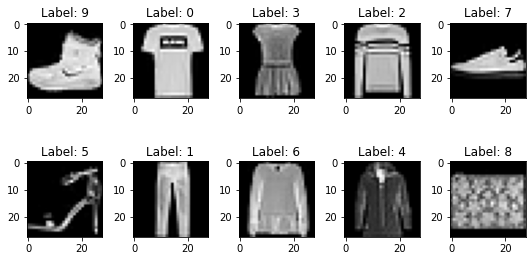

In [ ]:
'''
Code for plotting one image per each class, and visualizing it in Wandb media.
'''
num=10
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
wandb.log({'Clases':plt})

**Confusion Matrix and Testing**

In [ ]:
'''
Can Initialize a new project or use the previous own for Tetsing and Confusion matrix visualization.
'''
wandb.init(project=project, entity=entity)

In [ ]:
'''
Best parameters obtained from Hyper parameter tuning using Wandb sweep is set as the below parameters.
'''
epochs = 10
acti='tanh'
lr = 1e-4
batch_size = 64
optimizer="Nadam"
init_type="Xavier"
loss_type="SquaredError"
reg=0
hidden_size=128
no_hidden_layer=4



model = Neural_Network()

for i in range(no_hidden_layer):
        model.add(Layer(hidden_size, activation=acti))

model.add(Layer(10, activation='softmax'))
print(model.layers)
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, learning_rate=lr, optimizer=optimizer,val_split=0.1,init_type=init_type,loss_type=loss_type,reg=reg)
y_prob=model.predict(x_test)

{1: Hidden Units=128; Activation=tanh, 2: Hidden Units=128; Activation=tanh, 3: Hidden Units=128; Activation=tanh, 4: Hidden Units=128; Activation=tanh, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.022709852860788225 Train Acc: 80.33333333333333 Val Acc: 80.66666666666666 Val Loss: 0.02866113904264617
Epoch 2
Train Loss:0.019131424600151953 Train Acc: 82.83703703703705 Val Acc: 82.78333333333333 Val Loss: 0.024938602970812282
Epoch 3
Train Loss:0.017758438136765083 Train Acc: 84.07592592592592 Val Acc: 83.61666666666666 Val Loss: 0.023340243438281737
Epoch 4
Train Loss:0.016991174076524885 Train Acc: 84.93333333333334 Val Acc: 84.13333333333334 Val Loss: 0.022388584454208254
Epoch 5
Train Loss:0.0165414500829671 Train Acc: 85.51111111111112 Val Acc: 84.73333333333333 Val Loss: 0.0217372942493004
Epoch 6
Train Loss:0.0162053860202153 Train Acc: 85.95185185185186 Val Acc: 84.98333333333333 Val Loss: 0.02127446324340986
Epoch 7
Train Loss:0.015883079225300765 Train Acc: 86

In [ ]:
help=Helper()
accuracy=help.accuracy(y_test,y_prob)

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
x_test = x_test.reshape(x_test.shape[0], -1)
x_test = np.array(x_test/255., dtype=np.float32)

In [ ]:
y_prob=np.empty(np.shape(y_test))
for i,x in enumerate(x_test):
    y_prob[i]= (model.predict(x)[0]).argmax()

In [ ]:
y_test,y_prob.shape

(array([9, 2, 1, ..., 8, 1, 5], dtype=uint8), (10000,))

In [ ]:
'''
Confusion Matrix logging.
'''
wandb.log({"conf_mat" : wandb.plot.confusion_matrix(preds=y_prob, y_true=y_test, class_names=class_list),"Test Accuracy": accuracy })

Cross Entropy Vs Squared Error

In [ ]:
'''
Comparison of the Squared Error loss and Cross Entropy loss for best hyper paramter set.
'''
sweep_config = {
    'method': 'grid', #grid will be enough as only 2 sweeps will be made.
    'metric': {
      'name': 'Val/Accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [10]
        },
        'no_hidden_layer':{
            'values': [4]  
        },
        'learning_rate': {
            'values': [1e-4]
        },
        'opt': {
            'values': ['nadam']
        },
        'activation': {
            'values': ['tanh']
        },
        'batch_size':{
            'values':[64]
        },
        'size_hidden':{
            'values':[128]
        },
        'reg':{
            'values': [0]
        },
        'init_type':{
            'values': ['Xavier']  
        },
        'loss_type':{
            'values': ["SquaredError","CrossEntropy"]
        }
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity=entity, project=project)

Create sweep with ID: vnacwjk1
Sweep URL: https://wandb.ai/cs21m007_cs21m013/CE_vs_SE/sweeps/vnacwjk1


In [ ]:
'''
Method: train for running the sweep in Wandb.
'''
def train():
    steps = 0
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 10,
        'no_hidden_layer':4,
        'learning_rate': 1e-4,
        'opt':'nadam',
        'activation':'tanh',
        'batch_size':64,
        'size_hidden':128,
        'reg':0,
        'init_type':'Xavier',
        'loss_type':'CrossEntropy'
    }

    # Initialize a new wandb run
    wandb.init(project=project, entity=entity,config=config_defaults)
    
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    lr = config.learning_rate
    epochs = config.epochs
    opt = config.opt
    acti=config.activation
    batch_size = config.batch_size
    hidden_size=config.size_hidden
    reg=config.reg
    init_type=config.init_type
    no_hidden_layer=config.no_hidden_layer
    loss_type=config.loss_type
    if opt=="gd":
        opt="GD"
    elif opt=='adam':
      opt="Adam"
    elif opt=='rmsprop':
      opt="RMSprop"
    elif opt=='sgdm':
      opt='SGDM'
    elif opt=='nadam':
      opt="Nadam"
    elif opt=='nesterov':
      opt="Nesterov"
    # Model training here
    model = Neural_Network()
    for i in range(no_hidden_layer):
        model.add(Layer(hidden_size, activation=acti))

    model.add(Layer(10, activation='softmax'))
    print(model.layers)
    model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs, learning_rate=lr, optimizer=opt,val_split=0.1,init_type=init_type,loss_type=loss_type,reg=reg)

In [ ]:
'''
Run the 2 sweeps.
'''
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: ylsydl91 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: SquaredError
wandb: 	no_hidden_layer: 4
wandb: 	opt: nadam
wandb: 	reg: 0
wandb: 	size_hidden: 128
wandb: Currently logged in as: cs21m013 (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=tanh, 2: Hidden Units=128; Activation=tanh, 3: Hidden Units=128; Activation=tanh, 4: Hidden Units=128; Activation=tanh, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.022709852860788225 Train Acc: 80.33333333333333 Val Acc: 80.66666666666666 Val Loss: 0.02866113904264617
Epoch 2
Train Loss:0.019131424600151953 Train Acc: 82.83703703703705 Val Acc: 82.78333333333333 Val Loss: 0.024938602970812282
Epoch 3
Train Loss:0.017758438136765083 Train Acc: 84.07592592592592 Val Acc: 83.61666666666666 Val Loss: 0.023340243438281737
Epoch 4
Train Loss:0.016991174076524885 Train Acc: 84.93333333333334 Val Acc: 84.13333333333334 Val Loss: 0.022388584454208254
Epoch 5
Train Loss:0.0165414500829671 Train Acc: 85.51111111111112 Val Acc: 84.73333333333333 Val Loss: 0.0217372942493004
Epoch 6
Train Loss:0.0162053860202153 Train Acc: 85.95185185185186 Val Acc: 84.98333333333333 Val Loss: 0.02127446324340986
Epoch 7
Train Loss:0.015883079225300765 Train Acc: 86

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▄▅▆▆▇▇███
Train/Loss,█▅▃▃▂▂▂▁▁▁
Val/Accuracy,▁▄▅▅▆▇▇███
Val/Loss,█▅▄▃▂▂▂▁▁▁
Epoch,10
Train/Accuracy,86.96296
Train/Loss,0.01522
Val/Accuracy,86.08333
Val/Loss,0.02022


wandb: Agent Starting Run: xu7jxl7m with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_type: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	loss_type: CrossEntropy
wandb: 	no_hidden_layer: 4
wandb: 	opt: nadam
wandb: 	reg: 0
wandb: 	size_hidden: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


{1: Hidden Units=128; Activation=tanh, 2: Hidden Units=128; Activation=tanh, 3: Hidden Units=128; Activation=tanh, 4: Hidden Units=128; Activation=tanh, 5: Hidden Units=10; Activation=softmax}
Epoch 1
Train Loss:0.4567160706956943 Train Acc: 80.98148148148148 Val Acc: 80.71666666666667 Val Loss: 0.5602936770161041
Epoch 2
Train Loss:0.3851048841775676 Train Acc: 83.43888888888888 Val Acc: 82.88333333333333 Val Loss: 0.48152647359387674
Epoch 3
Train Loss:0.36373082302253873 Train Acc: 84.50740740740741 Val Acc: 84.08333333333333 Val Loss: 0.45083717304565385
Epoch 4
Train Loss:0.3503643670940318 Train Acc: 85.23518518518517 Val Acc: 84.78333333333333 Val Loss: 0.43336843875901393
Epoch 5
Train Loss:0.3382586797646013 Train Acc: 85.65 Val Acc: 85.08333333333333 Val Loss: 0.4214799842057032
Epoch 6
Train Loss:0.3273126771860541 Train Acc: 85.9462962962963 Val Acc: 85.48333333333333 Val Loss: 0.41254370738467033
Epoch 7
Train Loss:0.3181050215226275 Train Acc: 86.25555555555555 Val Acc: 8

Epoch,▁▂▃▃▄▅▆▆▇█
Train/Accuracy,▁▄▅▆▆▇▇▇██
Train/Loss,█▅▄▃▃▂▂▂▁▁
Val/Accuracy,▁▄▅▆▇▇▇▇██
Val/Loss,█▅▃▃▂▂▂▁▁▁
Epoch,10
Train/Accuracy,86.96481
Train/Loss,0.29363
Val/Accuracy,86.26667
Val/Loss,0.39041


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
